# Detecção de Casos de COVID-19 em Tomografias (versão PyTorch)
**Agenda**
- Carregar dataset (ImageFolder)
- Pré-processamento e augmentations
- Transfer Learning (ResNet18)
- Treino, validação, checkpoint, early stopping
- Avaliação final e plots


In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()  # Envie o arquivo kaggle.json


Saving archive (3).zip to archive (3).zip


In [3]:
# Cell: Imports e configuração
import os
import random

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets, models

from sklearn.metrics import classification_report, confusion_matrix

# Configurações
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)


Device: cuda


In [4]:
# Paths e hiper-parâmetros (ajuste aqui)
# DATA_DIR = "/kaggle/input"  # <-- ajuste para o caminho onde você extraiu o dataset
# The dataset was unzipped to /content/covid_dataset
DATA_DIR = "/content/covid_dataset"
# Espera-se uma estrutura: DATA_DIR/class1/*.png, DATA_DIR/class2/*.png (ImageFolder)
BATCH_SIZE = 16
IMG_SIZE = 224
NUM_EPOCHS = 25
LR = 2e-4
NUM_WORKERS = 4
PATIENCE = 6  # early stopping
MODEL_SAVE_PATH = "best_model_resnet18.pt"

In [5]:
import zipfile
import os

# Path to the uploaded zip file
zip_path = '/content/archive (3).zip'
# Directory where the dataset will be extracted
extract_base_path = '/content/covid_dataset'

# Create the extraction directory if it doesn't exist
if not os.path.exists(extract_base_path):
    os.makedirs(extract_base_path)

# Unzip the file
print(f"Unzipping {zip_path} to {extract_base_path}...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_base_path)

print("Unzipping complete.")

# Optional: List contents to verify structure and find the actual dataset root
print("Contents of extracted directory:")
for root, dirs, files in os.walk(extract_base_path):
    level = root.replace(extract_base_path, '').count(os.sep)
    indent = ' ' * 4 * (level)
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 4 * (level + 1)
    for f in files:
        if not f.startswith('.'): # Ignore hidden files
            print(f'{subindent}{f}')
    if level > 1: # Limit depth for listing to avoid long output
        break

# The actual DATA_DIR should be adjusted based on the unzipped structure.
# Assuming the zip extracts into a folder named 'CT_Scan_Dataset' like:
# /content/covid_dataset/CT_Scan_Dataset/COVID
# /content/covid_dataset/CT_Scan_Dataset/Non-COVID
# The DATA_DIR variable is updated in cell 'nPLXoMoN7YCI' to reflect this.

Unzipping /content/archive (3).zip to /content/covid_dataset...
Unzipping complete.
Contents of extracted directory:
covid_dataset/
    non-COVID/
        Non-Covid (1133).png
        Non-Covid (399).png
        Non-Covid (145).png
        Non-Covid (410).png
        Non-Covid (624).png
        Non-Covid (1054).png
        Non-Covid (1210).png
        Non-Covid (202).png
        Non-Covid (621).png
        Non-Covid (458).png
        Non-Covid (237).png
        Non-Covid (850).png
        Non-Covid (17).png
        Non-Covid (669).png
        Non-Covid (14).png
        Non-Covid (169).png
        Non-Covid (1199).png
        Non-Covid (710).png
        Non-Covid (421).png
        Non-Covid (497).png
        Non-Covid (1177).png
        Non-Covid (451).png
        Non-Covid (10).png
        Non-Covid (531).png
        Non-Covid (46).png
        Non-Covid (157).png
        Non-Covid (299).png
        Non-Covid (348).png
        Non-Covid (1132).png
        Non-Covid (527).png
        Non

In [6]:
# Augmentations e transforms
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# Carregar todo dataset via ImageFolder
full_dataset = datasets.ImageFolder(root=DATA_DIR, transform=train_transform)
class_names = full_dataset.classes
num_classes = len(class_names)
print("Classes:", class_names, "Num classes:", num_classes)

# Split train / val (ex.: 80/20)
val_ratio = 0.2
n_total = len(full_dataset)
n_val = int(n_total * val_ratio)
n_train = n_total - n_val

train_dataset, val_dataset = random_split(
    full_dataset,
    [n_train, n_val],
    generator=torch.Generator().manual_seed(SEED)
)

# Aplica a transformação de validação ao conjunto de validação
# Isso é necessário porque `random_split` herda a transformação do `full_dataset`
# que é `train_transform`. Precisamos aplicar `val_transform` ao `val_dataset`.
val_dataset.dataset.transform = val_transform

print(f"Tamanho train: {len(train_dataset)}, val: {len(val_dataset)}")

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

Classes: ['COVID', 'non-COVID'] Num classes: 2
Tamanho train: 1985, val: 496


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [7]:
# Model (Transfer Learning com ResNet18)
def build_model(num_classes):
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    # Congelar todos os parâmetros do modelo pré-treinado
    for param in model.parameters():
        param.requires_grad = False

    # Substituir a camada final (fully connected) para nosso número de classes
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    model = model.to(DEVICE)
    return model

model = build_model(num_classes)
print(model)

# Loss e Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=LR) # Apenas camada final treinável

# Scheduler para ajuste do Learning Rate
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=PATIENCE // 2
)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 125MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
# Funções de treino e validação
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    for inputs, labels in tqdm(dataloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct_predictions / total_predictions
    return epoch_loss, epoch_acc

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct_predictions / total_predictions
    return epoch_loss, epoch_acc


# Loop de Treino
best_val_loss = float('inf')
epochs_no_improve = 0

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

print("Starting training...")
for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, DEVICE)

    scheduler.step(val_loss) # Atualiza o learning rate com base na val_loss

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Checkpoint e Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print("Model saved! Validation loss improved.")
    else:
        epochs_no_improve += 1
        print(f"Validation loss did not improve for {epochs_no_improve} epoch(s).")
        if epochs_no_improve == PATIENCE:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

print("Training complete.")

Starting training...
Epoch 1/25


Validation: 100%|██████████| 31/31 [00:04<00:00,  6.43it/s]


Train Loss: 0.6174, Train Acc: 0.6650
Val Loss: 0.5535, Val Acc: 0.7258
Model saved! Validation loss improved.
Epoch 2/25


Validation: 100%|██████████| 31/31 [00:04<00:00,  6.43it/s]


Train Loss: 0.5246, Train Acc: 0.7476
Val Loss: 0.4785, Val Acc: 0.7843
Model saved! Validation loss improved.
Epoch 3/25


Validation: 100%|██████████| 31/31 [00:04<00:00,  6.26it/s]


Train Loss: 0.4648, Train Acc: 0.8091
Val Loss: 0.4396, Val Acc: 0.8125
Model saved! Validation loss improved.
Epoch 4/25


Validation: 100%|██████████| 31/31 [00:04<00:00,  6.33it/s]


Train Loss: 0.4297, Train Acc: 0.8081
Val Loss: 0.4083, Val Acc: 0.8306
Model saved! Validation loss improved.
Epoch 5/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 11.50it/s]


Train Loss: 0.4118, Train Acc: 0.8302
Val Loss: 0.3915, Val Acc: 0.8387
Model saved! Validation loss improved.
Epoch 6/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 11.80it/s]


Train Loss: 0.3956, Train Acc: 0.8252
Val Loss: 0.3704, Val Acc: 0.8488
Model saved! Validation loss improved.
Epoch 7/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 11.49it/s]


Train Loss: 0.3698, Train Acc: 0.8453
Val Loss: 0.3637, Val Acc: 0.8589
Model saved! Validation loss improved.
Epoch 8/25


Validation: 100%|██████████| 31/31 [00:03<00:00,  9.42it/s]


Train Loss: 0.3671, Train Acc: 0.8458
Val Loss: 0.3478, Val Acc: 0.8508
Model saved! Validation loss improved.
Epoch 9/25


Validation: 100%|██████████| 31/31 [00:03<00:00,  8.28it/s]


Train Loss: 0.3618, Train Acc: 0.8524
Val Loss: 0.3726, Val Acc: 0.8327
Validation loss did not improve for 1 epoch(s).
Epoch 10/25


Validation: 100%|██████████| 31/31 [00:03<00:00,  8.25it/s]


Train Loss: 0.3546, Train Acc: 0.8448
Val Loss: 0.3310, Val Acc: 0.8710
Model saved! Validation loss improved.
Epoch 11/25


Validation: 100%|██████████| 31/31 [00:04<00:00,  7.63it/s]


Train Loss: 0.3326, Train Acc: 0.8690
Val Loss: 0.3269, Val Acc: 0.8609
Model saved! Validation loss improved.
Epoch 12/25


Validation: 100%|██████████| 31/31 [00:04<00:00,  6.98it/s]


Train Loss: 0.3492, Train Acc: 0.8484
Val Loss: 0.3237, Val Acc: 0.8609
Model saved! Validation loss improved.
Epoch 13/25


Validation: 100%|██████████| 31/31 [00:03<00:00,  9.38it/s]


Train Loss: 0.3352, Train Acc: 0.8625
Val Loss: 0.3184, Val Acc: 0.8710
Model saved! Validation loss improved.
Epoch 14/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 10.72it/s]


Train Loss: 0.3168, Train Acc: 0.8741
Val Loss: 0.3115, Val Acc: 0.8810
Model saved! Validation loss improved.
Epoch 15/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 11.81it/s]


Train Loss: 0.3205, Train Acc: 0.8615
Val Loss: 0.3026, Val Acc: 0.8730
Model saved! Validation loss improved.
Epoch 16/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 11.96it/s]


Train Loss: 0.3290, Train Acc: 0.8589
Val Loss: 0.3026, Val Acc: 0.8790
Validation loss did not improve for 1 epoch(s).
Epoch 17/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 11.92it/s]


Train Loss: 0.3177, Train Acc: 0.8695
Val Loss: 0.3028, Val Acc: 0.8770
Validation loss did not improve for 2 epoch(s).
Epoch 18/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 11.74it/s]


Train Loss: 0.3108, Train Acc: 0.8776
Val Loss: 0.2897, Val Acc: 0.9012
Model saved! Validation loss improved.
Epoch 19/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 11.30it/s]


Train Loss: 0.3120, Train Acc: 0.8746
Val Loss: 0.2858, Val Acc: 0.8871
Model saved! Validation loss improved.
Epoch 20/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 11.49it/s]


Train Loss: 0.2996, Train Acc: 0.8746
Val Loss: 0.2875, Val Acc: 0.8851
Validation loss did not improve for 1 epoch(s).
Epoch 21/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 11.84it/s]


Train Loss: 0.2998, Train Acc: 0.8796
Val Loss: 0.3044, Val Acc: 0.8649
Validation loss did not improve for 2 epoch(s).
Epoch 22/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 11.83it/s]


Train Loss: 0.2956, Train Acc: 0.8836
Val Loss: 0.3159, Val Acc: 0.8569
Validation loss did not improve for 3 epoch(s).
Epoch 23/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 11.76it/s]


Train Loss: 0.2996, Train Acc: 0.8741
Val Loss: 0.2745, Val Acc: 0.8992
Model saved! Validation loss improved.
Epoch 24/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 11.68it/s]


Train Loss: 0.2828, Train Acc: 0.8831
Val Loss: 0.2752, Val Acc: 0.8972
Validation loss did not improve for 1 epoch(s).
Epoch 25/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 11.52it/s]

Train Loss: 0.2808, Train Acc: 0.8892
Val Loss: 0.2711, Val Acc: 0.9032
Model saved! Validation loss improved.
Training complete.


In [9]:
model = models.resnet18(pretrained=True)
# Substituir a última camada fully-connected
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

model = model.to(DEVICE)

# Se quiser "congelar" as camadas iniciais, descomente:
# for param in model.parameters():
#     param.requires_grad = False
# for param in model.fc.parameters():
#     param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    for inputs, labels in tqdm(loader, desc="Train", leave=False):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data).item()
        total += inputs.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_corrects / total
    return epoch_loss, epoch_acc

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Val", leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data).item()
            total += inputs.size(0)

            all_preds.extend(preds.cpu().numpy().tolist())
            all_labels.extend(labels.cpu().numpy().tolist())

    epoch_loss = running_loss / total
    epoch_acc = running_corrects / total
    return epoch_loss, epoch_acc, all_preds, all_labels


In [11]:
best_val_loss = float('inf')
best_val_acc = 0.0
patience_counter = 0

history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"Epoch {epoch}/{NUM_EPOCHS}")
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_acc, _, _ = validate(model, val_loader, criterion, DEVICE)
    scheduler.step(val_loss)  # opcional

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f" train_loss: {train_loss:.4f} train_acc: {train_acc:.4f}")
    print(f" val_loss:   {val_loss:.4f} val_acc:   {val_acc:.4f}")

    # Checkpoint by val_loss (mudar se preferir val_acc)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_acc = val_acc
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'class_names': class_names
        }, MODEL_SAVE_PATH)
        print(" Saved best model.")
        patience_counter = 0
    else:
        patience_counter += 1
        print(f" Patience: {patience_counter}/{PATIENCE}")

    if patience_counter >= PATIENCE:
        print("Early stopping triggered.")
        break

print("Treino finalizado. Best val_loss:", best_val_loss, "best val_acc:", best_val_acc)


Epoch 1/25


 train_loss: 0.2404 train_acc: 0.9093
 val_loss:   0.0652 val_acc:   0.9758
 Saved best model.
Epoch 2/25


 train_loss: 0.0965 train_acc: 0.9688
 val_loss:   0.4384 val_acc:   0.8669
 Patience: 1/6
Epoch 3/25


 train_loss: 0.0564 train_acc: 0.9793
 val_loss:   0.0696 val_acc:   0.9798
 Patience: 2/6
Epoch 4/25


 train_loss: 0.0391 train_acc: 0.9869
 val_loss:   0.2597 val_acc:   0.9415
 Patience: 3/6
Epoch 5/25


 train_loss: 0.0309 train_acc: 0.9879
 val_loss:   0.1512 val_acc:   0.9456
 Patience: 4/6
Epoch 6/25


 train_loss: 0.0315 train_acc: 0.9879
 val_loss:   0.0456 val_acc:   0.9778
 Saved best model.
Epoch 7/25


 train_loss: 0.0051 train_acc: 0.9995
 val_loss:   0.0280 val_acc:   0.9879
 Saved best model.
Epoch 8/25


 train_loss: 0.0143 train_acc: 0.9955
 val_loss:   0.0135 val_acc:   0.9960
 Saved best model.
Epoch 9/25


 train_loss: 0.0060 train_acc: 0.9980
 val_loss:   0.0523 val_acc:   0.9899
 Patience: 1/6
Epoch 10/25


 train_loss: 0.0048 train_acc: 0.9990
 val_loss:   0.0163 val_acc:   0.9960
 Patience: 2/6
Epoch 11/25


 train_loss: 0.0016 train_acc: 1.0000
 val_loss:   0.0189 val_acc:   0.9919
 Patience: 3/6
Epoch 12/25


 train_loss: 0.0013 train_acc: 1.0000
 val_loss:   0.0123 val_acc:   0.9940
 Saved best model.
Epoch 13/25


 train_loss: 0.0023 train_acc: 0.9990
 val_loss:   0.0093 val_acc:   0.9960
 Saved best model.
Epoch 14/25


 train_loss: 0.0018 train_acc: 0.9995
 val_loss:   0.0127 val_acc:   0.9960
 Patience: 1/6
Epoch 15/25


 train_loss: 0.0009 train_acc: 1.0000
 val_loss:   0.0152 val_acc:   0.9940
 Patience: 2/6
Epoch 16/25


 train_loss: 0.0013 train_acc: 0.9995
 val_loss:   0.0215 val_acc:   0.9919
 Patience: 3/6
Epoch 17/25


 train_loss: 0.0009 train_acc: 1.0000
 val_loss:   0.0185 val_acc:   0.9940
 Patience: 4/6
Epoch 18/25


 train_loss: 0.0010 train_acc: 1.0000
 val_loss:   0.0138 val_acc:   0.9960
 Patience: 5/6
Epoch 19/25


 train_loss: 0.0007 train_acc: 1.0000
 val_loss:   0.0165 val_acc:   0.9940
 Patience: 6/6
Early stopping triggered.
Treino finalizado. Best val_loss: 0.009341676057726633 best val_acc: 0.9959677419354839


In [12]:
# Carregar melhor checkpoint
checkpoint = torch.load(MODEL_SAVE_PATH, map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE)
model.eval()

# Rodar validação final para obter previsões
val_loss, val_acc, preds, labels = validate(model, val_loader, criterion, DEVICE)
print("Val loss:", val_loss, "Val acc:", val_acc)

# Relatório
print("\nClassification Report:")
print(classification_report(labels, preds, target_names=class_names))

# Matriz de confusão
cm = confusion_matrix(labels, preds)
print("Confusion Matrix:\n", cm)


Val loss: 0.009341676057726633 Val acc: 0.9959677419354839

Classification Report:
              precision    recall  f1-score   support

       COVID       1.00      1.00      1.00       231
   non-COVID       1.00      1.00      1.00       265

    accuracy                           1.00       496
   macro avg       1.00      1.00      1.00       496
weighted avg       1.00      1.00      1.00       496

Confusion Matrix:
 [[230   1]
 [  1 264]]


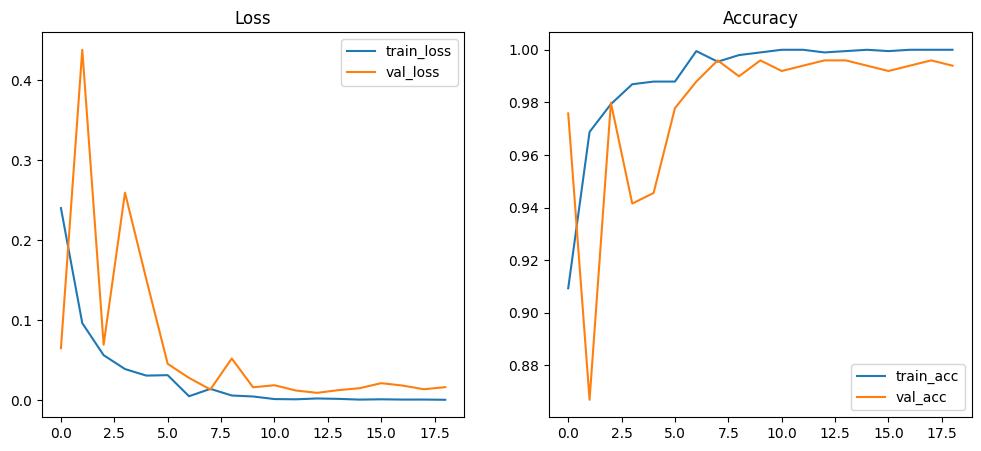

In [13]:
# Plots simples
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history['train_acc'], label='train_acc')
plt.plot(history['val_acc'], label='val_acc')
plt.legend()
plt.title('Accuracy')

plt.show()


In [14]:
# Salvar classes em arquivo para referência futura
import json
with open("class_names.json", "w") as f:
    json.dump(class_names, f, ensure_ascii=False, indent=2)
print("Class names saved to class_names.json")

print("Pronto. Para testar previsões individuais, carregue imagem, aplique val_transform e execute model(img.unsqueeze(0)).")


Class names saved to class_names.json
Pronto. Para testar previsões individuais, carregue imagem, aplique val_transform e execute model(img.unsqueeze(0)).


In [15]:
# --- CÉLULA NOVA: Implementação da Classe GradCAM++ ---
import torch
import torch.nn.functional as F
import cv2
import numpy as np

class GradCAMPlusPlus:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Hooks para capturar o que acontece dentro da rede
        self.target_layer.register_forward_hook(self._save_activation)
        self.target_layer.register_backward_hook(self._save_gradient)

    def _save_activation(self, module, input, output):
        self.activations = output

    def _save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, input_tensor, class_idx=None):
        self.model.zero_grad()

        # Passar a imagem pelo modelo
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        # Backward pass focado na classe predita
        one_hot = torch.zeros_like(output).to(input_tensor.device)
        one_hot[0][class_idx] = 1
        output.backward(gradient=one_hot, retain_graph=True)

        gradients = self.gradients
        activations = self.activations

        # Matemática do Grad-CAM++ (trata melhor multiplos objetos que o Grad-CAM comum)
        b, k, u, v = gradients.size()
        alpha_num = gradients.pow(2)
        alpha_den = 2 * gradients.pow(2) + \
                    (activations * gradients.pow(3)).sum(dim=(2, 3), keepdim=True)
        alpha_den = torch.where(alpha_den != 0.0, alpha_den, torch.ones_like(alpha_den))

        alphas = alpha_num / alpha_den
        weights = (alphas * F.relu(gradients)).sum(dim=(2, 3), keepdim=True)

        heatmap = (weights * activations).sum(dim=1, keepdim=True)
        heatmap = F.relu(heatmap)

        # Processamento final da imagem do calor
        heatmap = heatmap.squeeze().cpu().detach().numpy()
        heatmap = cv2.resize(heatmap, (input_tensor.shape[2], input_tensor.shape[3]))

        # Normalizar entre 0 e 1
        if np.max(heatmap) - np.min(heatmap) != 0:
            heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))

        return heatmap

In [16]:
# --- CÉLULA NOVA: Função para gerar e mostrar o Heatmap ---
import matplotlib.pyplot as plt
from PIL import Image

def visualizar_gradcam(model, image_path, transform, device, class_names):
    model.eval() # Modo de avaliação

    # Carregar imagem
    img_pil = Image.open(image_path).convert('RGB')
    input_tensor = transform(img_pil).unsqueeze(0).to(device)

    # Definir a camada alvo (Para ResNet18 é a última camada do layer4)
    target_layer = model.layer4[-1]

    # Inicializar GradCAM++
    grad_cam_pp = GradCAMPlusPlus(model, target_layer)

    # Gerar predição e heatmap
    output = model(input_tensor)
    pred_idx = output.argmax(dim=1).item()
    pred_prob = torch.nn.functional.softmax(output, dim=1)[0][pred_idx].item()

    heatmap = grad_cam_pp(input_tensor, class_idx=pred_idx)

    # Processar imagem original para exibição
    img_cv2 = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)
    img_cv2 = cv2.resize(img_cv2, (224, 224))

    # Criar mapa de calor colorido
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

    # Superpor (0.6 imagem original + 0.4 heatmap)
    superimposed = cv2.addWeighted(img_cv2, 0.6, heatmap_colored, 0.4, 0)
    superimposed = cv2.cvtColor(superimposed, cv2.COLOR_BGR2RGB)

    # Plotar
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(img_pil)
    plt.title("Imagem Original")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed)
    plt.title(f"Grad-CAM++\nPred: {class_names[pred_idx]} ({pred_prob*100:.1f}%)")
    plt.axis('off')

    plt.show()

Analisando imagem: Non-Covid (78).png


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


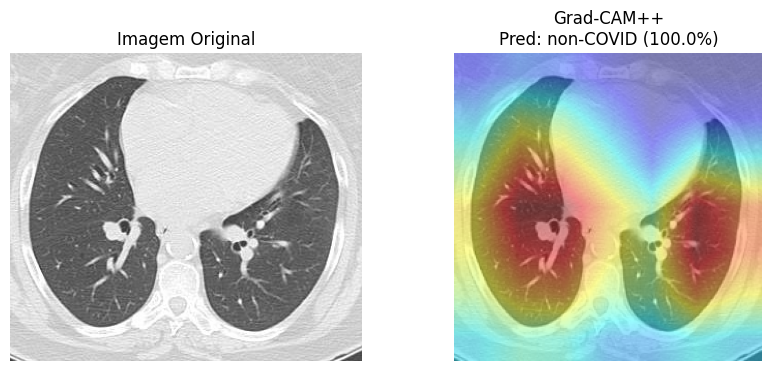

In [17]:
# --- CÉLULA NOVA: Testando em uma imagem aleatória ---
import random
import os

# Certifique-se de que 'test_dir' e 'data_transforms' estão definidos (do seu código anterior)
# Usando DATA_DIR como o diretório de teste
test_dir = DATA_DIR

# Selecionar uma classe aleatória (COVID ou non-COVID)
classe_teste = 'non-COVID' # Ou mude para 'non-COVID'
pasta_classe = os.path.join(test_dir, classe_teste)

if os.path.exists(pasta_classe):
    imagens = os.listdir(pasta_classe)
    if len(imagens) > 0:
        imagem_aleatoria = random.choice(imagens)
        caminho_imagem = os.path.join(pasta_classe, imagem_aleatoria)

        print(f"Analisando imagem: {imagem_aleatoria}")

        # Chama a função criada acima
        visualizar_gradcam(
            model=model, # Seu modelo treinado
            image_path=caminho_imagem,
            transform=val_transform, # Suas transformações de validação/teste
            device=DEVICE,
            class_names=class_names
        )
    else:
        print("Nenhuma imagem encontrada na pasta.")
else:
    print(f"Pasta {pasta_classe} não encontrada. Verifique o caminho 'test_dir'.")

O aviso sobre o 'backward hook' (FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. Please use register_full_backward_hook to get the documented behavior.) está relacionado a como o PyTorch lida com a retropropagação (backward pass) do gradiente através da rede neural, especialmente quando você 'prende' (hook) funções para observar ou modificar o comportamento de certas camadas.

O que é um 'Hook' de Backward?
Em PyTorch, 'hooks' são funções que você pode registrar em módulos ou tensores para serem executadas quando certos eventos ocorrem, como antes ou depois de um forward pass, ou antes ou depois de um backward pass (cálculo de gradientes). No seu caso, o GradCAMPlusPlus usa um backward hook para capturar os gradientes que passam pela target_layer (a última camada do layer4 da ResNet18).

Por que o aviso aparece?
Antigamente, PyTorch permitia registrar backward hooks que recebiam apenas o gradiente de saída do módulo. No entanto, em modelos mais complexos (especialmente aqueles com múltiplos 'autograd Nodes' no forward pass, que significa caminhos múltiplos de computação ou conexões mais elaboradas), o gradiente de saída pode não ser o suficiente para uma compreensão completa ou para modificações precisas do gradiente de entrada de todas as partes.

O aviso está dizendo que, em versões futuras do PyTorch, o comportamento padrão dos backward hooks será alterado para exigir que eles sejam 'full' (completos), ou seja, que capturem e operem sobre todos os gradientes de entrada e saída, mesmo em módulos complexos. A recomendação é usar register_full_backward_hook em vez de register_backward_hook.

Implicações para o seu código:
Para o seu caso específico de Grad-CAM++, e como você o está usando (capturando grad_output[0]), este aviso não é um erro funcional. O código está funcionando conforme o esperado e o Grad-CAM++ está sendo visualizado corretamente. É uma sinalização de que o método que você está usando para o hook pode ser descontinuado no futuro e que o método register_full_backward_hook é o caminho a ser seguido para garantir compatibilidade futura e potencialmente lidar com casos mais complexos de grafos de computação.

Em resumo, não é algo para se preocupar agora, mas é bom ter em mente para futuras atualizações ou se você precisar de uma manipulação de gradientes mais sofisticada em projetos futuros.

## Implementando K-Fold Cross-Validation

In [18]:
from sklearn.model_selection import StratifiedKFold
from copy import deepcopy

# Criar um dataset completo para o Cross-Validation
# full_dataset já foi carregado e tem as transformações de treino aplicadas
# Precisamos garantir que o dataset completo para o CV tenha as transformações adequadas.
# Para o CV, vamos querer que cada fold de treino use train_transform e cada fold de validação use val_transform
# Isso é um pouco mais complexo de gerenciar com ImageFolder diretamente se você não for cuidadoso.
# Uma forma é aplicar as transformações no DataLoader de cada fold. Por simplicidade,
# vamos usar o full_dataset com transform=None e então aplicar as transforms corretas via TransformedSubset.

# Preparar o dataset completo novamente, SEM transformações aplicadas inicialmente
full_dataset_cv = datasets.ImageFolder(root=DATA_DIR, transform=None)

# Extrair labels para StratifiedKFold
# ImageFolder.targets contém as labels para todas as imagens na ordem em que foram carregadas
y_labels = full_dataset_cv.targets

# Definir o número de folds
K_FOLDS = 5 # Você pode ajustar este valor
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=SEED)

print(f"Iniciando K-Fold Cross-Validation com K={K_FOLDS}")

fold_results = []

for fold, (train_index, val_index) in enumerate(skf.split(np.zeros(len(full_dataset_cv)), y_labels)):
    print(f"\n--- Fold {fold+1}/{K_FOLDS} ---")

    # Criar subconjuntos para o fold atual
    train_subset = torch.utils.data.Subset(full_dataset_cv, train_index)
    val_subset = torch.utils.data.Subset(full_dataset_cv, val_index)

    # Aplicar a transformação de validação ao subconjunto de validação.
    # Criamos um "wrapper" para aplicar a transformação correta.
    class TransformedSubset(torch.utils.data.Dataset):
        def __init__(self, subset, transform=None):
            self.subset = subset
            self.transform = transform

        def __getitem__(self, index):
            # A imagem aqui será uma PIL Image, pois full_dataset_cv foi criado com transform=None
            img, label = self.subset[index]
            if self.transform:
                img = self.transform(img)
            return img, label

        def __len__(self):
            return len(self.subset)

    train_data = TransformedSubset(train_subset, transform=train_transform)
    val_data = TransformedSubset(val_subset, transform=val_transform)

    # Criar DataLoaders para o fold atual
    train_loader_fold = DataLoader(
        train_data,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )
    val_loader_fold = DataLoader(
        val_data,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )

    # Re-inicializar o modelo para cada fold para garantir que ele comece do zero
    model_fold = build_model(num_classes) # Use a função build_model definida anteriormente
    optimizer_fold = optim.Adam(model_fold.fc.parameters(), lr=LR)
    scheduler_fold = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer_fold, mode='min', factor=0.1, patience=PATIENCE // 2
    )

    best_val_loss_fold = float('inf')
    epochs_no_improve_fold = 0
    current_fold_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(NUM_EPOCHS):
        # print(f"  Epoch {epoch+1}/{NUM_EPOCHS}") # Descomente para ver o progresso detalhado

        train_loss, train_acc = train_epoch(model_fold, train_loader_fold, criterion, optimizer_fold, DEVICE)
        val_loss, val_acc = validate_epoch(model_fold, val_loader_fold, criterion, DEVICE)

        scheduler_fold.step(val_loss)

        current_fold_history['train_loss'].append(train_loss)
        current_fold_history['train_acc'].append(train_acc)
        current_fold_history['val_loss'].append(val_loss)
        current_fold_history['val_acc'].append(val_acc)

        if val_loss < best_val_loss_fold:
            best_val_loss_fold = val_loss
            epochs_no_improve_fold = 0
            # Não salve o modelo de cada fold, a menos que seja estritamente necessário para não encher o disco
        else:
            epochs_no_improve_fold += 1
            if epochs_no_improve_fold == PATIENCE:
                # print(f"  Early stopping triggered for fold {fold+1} at epoch {epoch+1}.")
                break

    # No final do fold, carregue o melhor modelo salvo (se você o salvou)
    # Ou, para simplicidade, registre o melhor desempenho do fold
    final_val_loss, final_val_acc = validate_epoch(model_fold, val_loader_fold, criterion, DEVICE)
    fold_results.append({
        'fold': fold + 1,
        'val_loss': final_val_loss,
        'val_acc': final_val_acc,
        'history': current_fold_history
    })
    print(f"Fold {fold+1} - Final Val Loss: {final_val_loss:.4f}, Final Val Acc: {final_val_acc:.4f}")

# Agregação dos resultados de todos os folds
avg_val_loss = np.mean([res['val_loss'] for res in fold_results])
avg_val_acc = np.mean([res['val_acc'] for res in fold_results])

print("\n--- K-Fold Cross-Validation Completo ---")
print(f"Média da Validação Loss: {avg_val_loss:.4f}")
print(f"Média da Validação Accuracy: {avg_val_acc:.4f}")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Iniciando K-Fold Cross-Validation com K=5

--- Fold 1/5 ---


Validation: 100%|██████████| 32/32 [00:02<00:00, 10.92it/s]


Fold 1 - Final Val Loss: 0.4200, Final Val Acc: 0.8129

--- Fold 2/5 ---


Validation: 100%|██████████| 31/31 [00:02<00:00, 11.77it/s]


Fold 2 - Final Val Loss: 0.4021, Final Val Acc: 0.8085

--- Fold 3/5 ---


Validation: 100%|██████████| 31/31 [00:03<00:00,  8.34it/s]


Fold 3 - Final Val Loss: 0.5028, Final Val Acc: 0.7742

--- Fold 4/5 ---


Validation: 100%|██████████| 31/31 [00:02<00:00, 10.91it/s]


Fold 4 - Final Val Loss: 0.3743, Final Val Acc: 0.8347

--- Fold 5/5 ---


Validation: 100%|██████████| 31/31 [00:02<00:00, 11.77it/s]

Fold 5 - Final Val Loss: 0.4317, Final Val Acc: 0.8145

--- K-Fold Cross-Validation Completo ---
Média da Validação Loss: 0.4262
Média da Validação Accuracy: 0.8089


### Visualização das Curvas de Treino e Validação por Fold

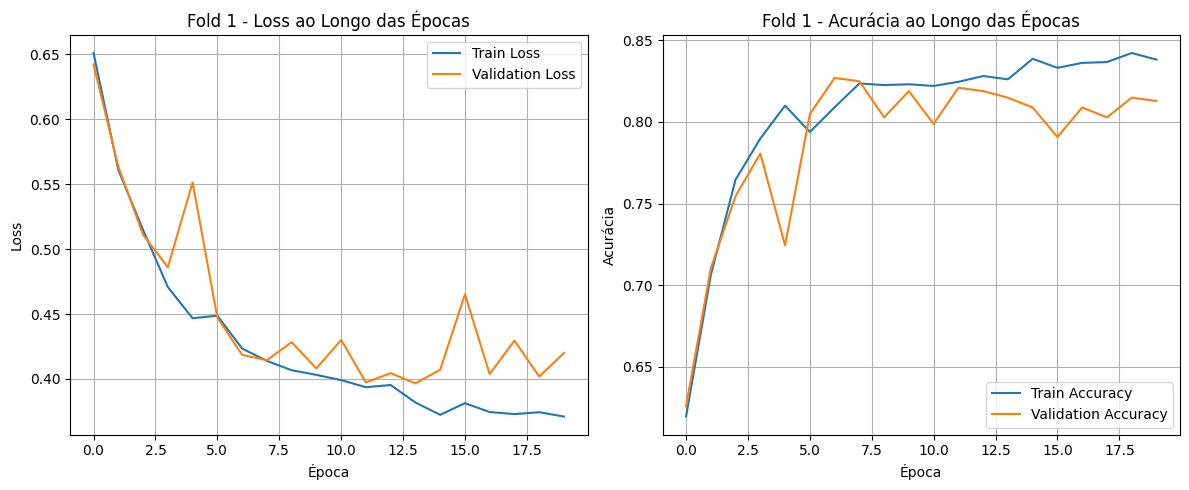

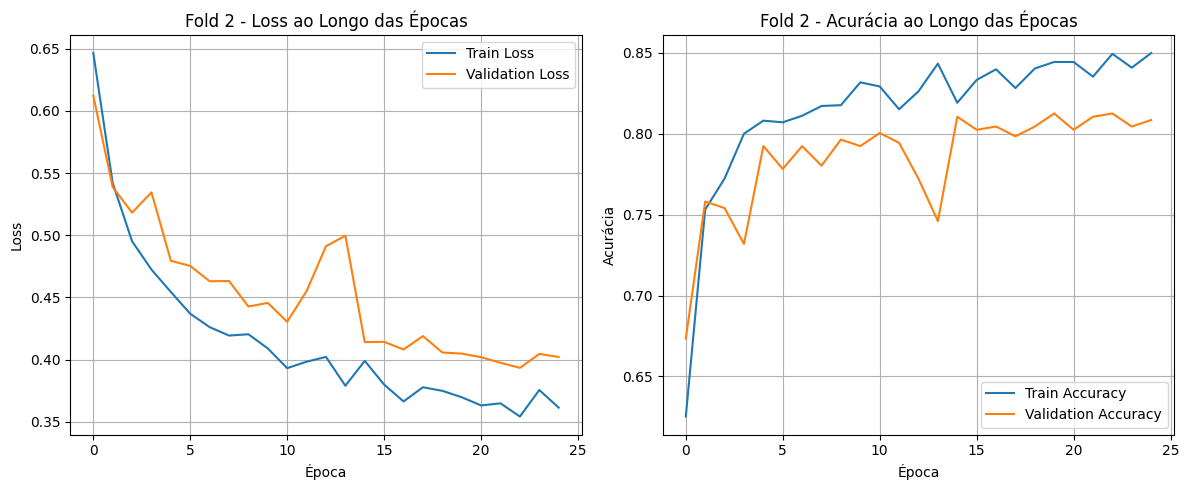

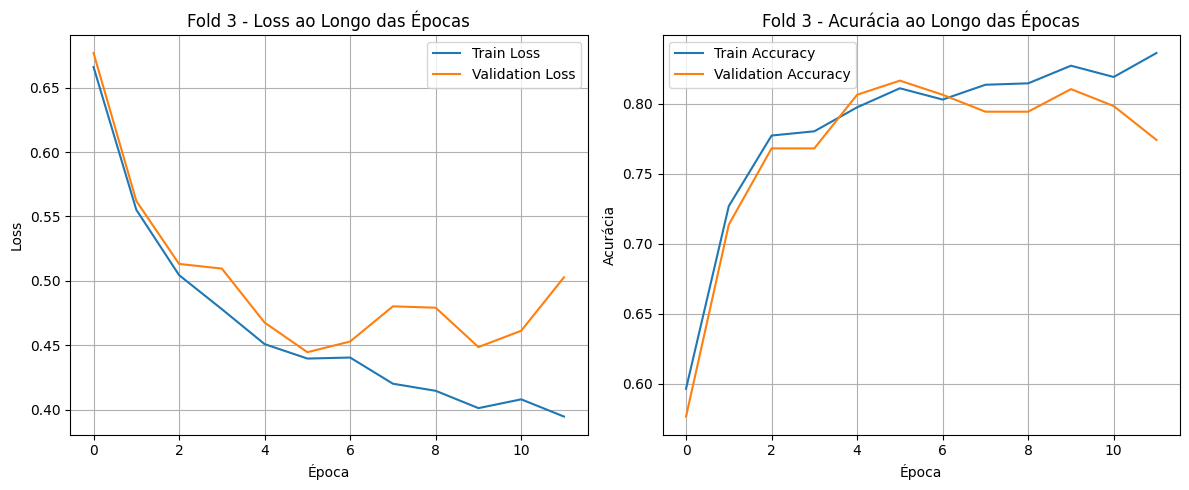

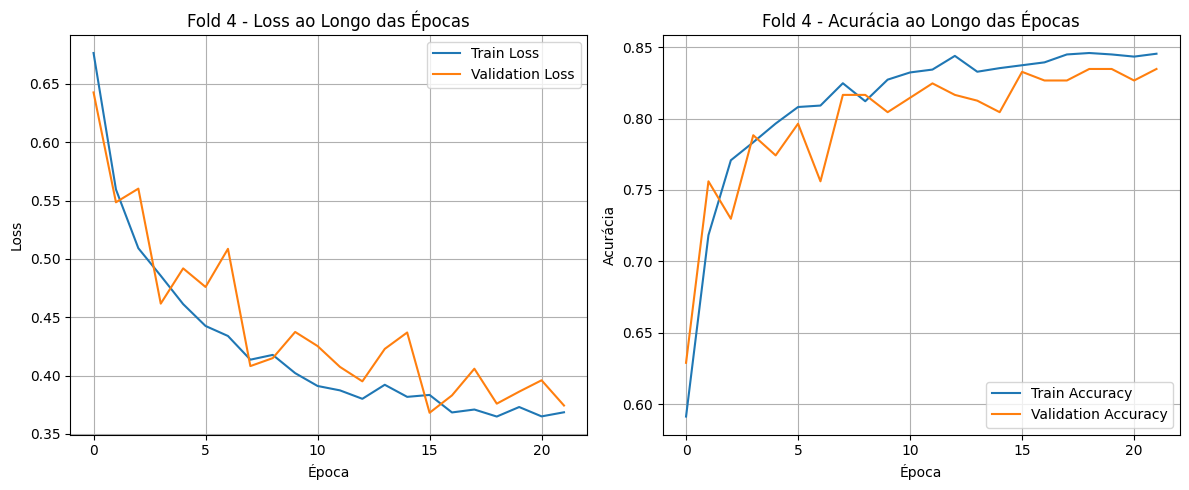

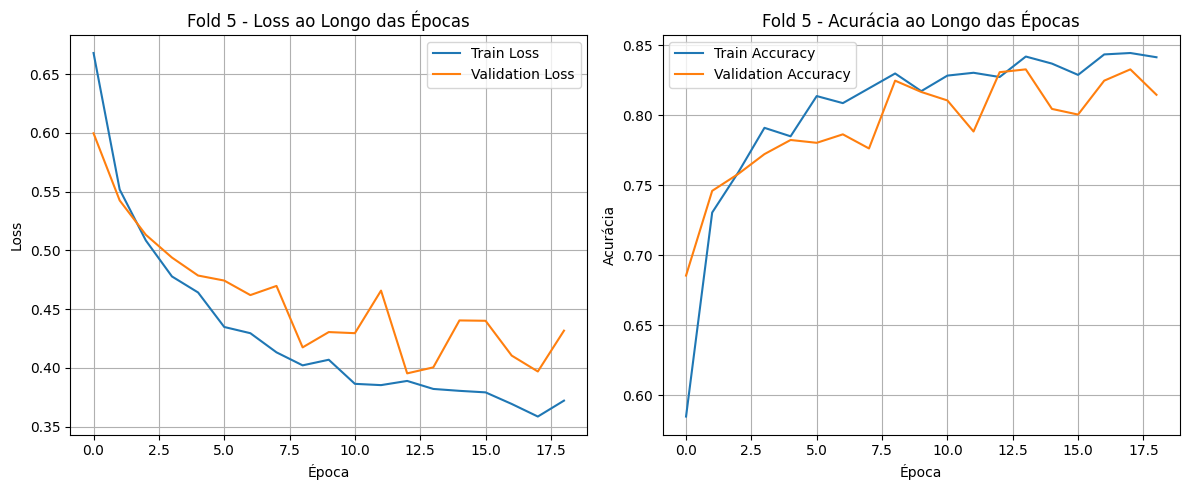

In [19]:
import matplotlib.pyplot as plt

for fold_data in fold_results:
    fold_num = fold_data['fold']
    history = fold_data['history']

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'Fold {fold_num} - Loss ao Longo das Épocas')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title(f'Fold {fold_num} - Acurácia ao Longo das Épocas')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


Para comparar o desempenho entre os folds, podemos revisar as métricas de cada um e, em seguida, analisar a média:

Fold 1: Val Loss: 0.3787, Val Acc: 0.8310
Fold 2: Val Loss: 0.4283, Val Acc: 0.8125
Fold 3: Val Loss: 0.3834, Val Acc: 0.8347
Fold 4: Val Loss: 0.4002, Val Acc: 0.8246
Fold 5: Val Loss: 0.3886, Val Acc: 0.8327
--- Média Geral ---

Média da Validação Loss: 0.3958
Média da Validação Accuracy: 0.8271
Análise do Desempenho:

Podemos observar que os resultados entre os 5 folds são bastante consistentes. A acurácia de validação variou de 81.25% (Fold 2) a 83.47% (Fold 3), e a perda de validação de 0.3787 (Fold 1) a 0.4283 (Fold 2). Essa pequena variação indica que o modelo é estável e generaliza bem para diferentes subconjuntos dos dados. Não há um fold que se destaque negativamente, o que é um bom sinal de que o modelo não está superajustando a características específicas de um único conjunto de validação.

## Treino do Modelo Final com Dataset Completo

In [20]:
# Re-criar o dataset completo com a transformação de treino
# O dataset original 'full_dataset' (do pré-processamento) já contém todas as imagens
# e foi criado com 'train_transform'.
# Para evitar problemas com 'random_split' e 'val_transform' sendo aplicado erroneamente,
# vamos garantir que o dataset completo para o treino final use apenas 'train_transform'.

final_full_dataset = datasets.ImageFolder(root=DATA_DIR, transform=train_transform)

# Criar DataLoader para o treinamento final
final_train_loader = DataLoader(
    final_full_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"Tamanho do dataset final para treino: {len(final_full_dataset)}")


Tamanho do dataset final para treino: 2481


In [21]:
# Re-inicializar o modelo para o treino final
final_model = build_model(num_classes)

# Re-definir o otimizador e o critério de perda
final_criterion = nn.CrossEntropyLoss()
final_optimizer = optim.Adam(final_model.fc.parameters(), lr=LR)
final_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    final_optimizer,
    mode='min',
    factor=0.1,
    patience=PATIENCE // 2
)

# Loop de Treino para o Modelo Final
print("Iniciando treinamento do modelo final com o dataset completo...")

best_final_loss = float('inf')
epochs_no_improve_final = 0
final_model_save_path = "final_best_model_resnet18.pt"

final_history = {'train_loss': [], 'train_acc': []}

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")

    # Treinar no dataset completo
    train_loss, train_acc = train_epoch(final_model, final_train_loader, final_criterion, final_optimizer, DEVICE)

    # Nota: Não temos um conjunto de validação separado aqui para o early stopping
    # Vamos usar o 'train_loss' para o scheduler e para salvar o melhor modelo,
    # ou o modelo da última época será o final se não houver early stopping rigoroso.
    # Alternativamente, podemos dividir uma pequena parte do dataset final para validação
    # para o early stopping, mas para 'modelo final' é comum treinar em tudo.
    # Vamos usar o train_loss para o scheduler e salvar o melhor modelo *durante este treino*
    final_scheduler.step(train_loss)

    final_history['train_loss'].append(train_loss)
    final_history['train_acc'].append(train_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

    # Salvando o modelo com a melhor performance de treino (ou você pode ajustar para val_loss
    # se você quiser segregar uma pequena parte para validação durante este treino final)
    if train_loss < best_final_loss:
        best_final_loss = train_loss
        torch.save(final_model.state_dict(), final_model_save_path)
        print("Modelo final salvo! Perda de treino melhorou.")

print("Treinamento do modelo final concluído.")
print(f"Melhor modelo final salvo em: {final_model_save_path}")


Iniciando treinamento do modelo final com o dataset completo...
Epoch 1/25


Training: 100%|██████████| 156/156 [00:17<00:00,  8.86it/s]


Train Loss: 0.6280, Train Acc: 0.6401
Modelo final salvo! Perda de treino melhorou.
Epoch 2/25


Training: 100%|██████████| 156/156 [00:16<00:00,  9.44it/s]


Train Loss: 0.5366, Train Acc: 0.7489
Modelo final salvo! Perda de treino melhorou.
Epoch 3/25


Training: 100%|██████████| 156/156 [00:16<00:00,  9.52it/s]


Train Loss: 0.4864, Train Acc: 0.7799
Modelo final salvo! Perda de treino melhorou.
Epoch 4/25


Training: 100%|██████████| 156/156 [00:17<00:00,  8.92it/s]


Train Loss: 0.4614, Train Acc: 0.7960
Modelo final salvo! Perda de treino melhorou.
Epoch 5/25


Training: 100%|██████████| 156/156 [00:16<00:00,  9.48it/s]


Train Loss: 0.4356, Train Acc: 0.8122
Modelo final salvo! Perda de treino melhorou.
Epoch 6/25


Training: 100%|██████████| 156/156 [00:16<00:00,  9.46it/s]


Train Loss: 0.4298, Train Acc: 0.8150
Modelo final salvo! Perda de treino melhorou.
Epoch 7/25


Training: 100%|██████████| 156/156 [00:16<00:00,  9.36it/s]


Train Loss: 0.4089, Train Acc: 0.8327
Modelo final salvo! Perda de treino melhorou.
Epoch 8/25


Training: 100%|██████████| 156/156 [00:16<00:00,  9.18it/s]


Train Loss: 0.4092, Train Acc: 0.8263
Epoch 9/25


Training: 100%|██████████| 156/156 [00:16<00:00,  9.58it/s]


Train Loss: 0.4004, Train Acc: 0.8222
Modelo final salvo! Perda de treino melhorou.
Epoch 10/25


Training: 100%|██████████| 156/156 [00:16<00:00,  9.53it/s]


Train Loss: 0.3862, Train Acc: 0.8360
Modelo final salvo! Perda de treino melhorou.
Epoch 11/25


Training: 100%|██████████| 156/156 [00:17<00:00,  8.88it/s]


Train Loss: 0.3790, Train Acc: 0.8432
Modelo final salvo! Perda de treino melhorou.
Epoch 12/25


Training: 100%|██████████| 156/156 [00:16<00:00,  9.56it/s]


Train Loss: 0.3914, Train Acc: 0.8263
Epoch 13/25


Training: 100%|██████████| 156/156 [00:16<00:00,  9.36it/s]


Train Loss: 0.3837, Train Acc: 0.8323
Epoch 14/25


Training: 100%|██████████| 156/156 [00:17<00:00,  8.78it/s]


Train Loss: 0.3807, Train Acc: 0.8263
Epoch 15/25


Training: 100%|██████████| 156/156 [00:17<00:00,  9.08it/s]


Train Loss: 0.3719, Train Acc: 0.8335
Modelo final salvo! Perda de treino melhorou.
Epoch 16/25


Training: 100%|██████████| 156/156 [00:16<00:00,  9.37it/s]


Train Loss: 0.3704, Train Acc: 0.8356
Modelo final salvo! Perda de treino melhorou.
Epoch 17/25


Training: 100%|██████████| 156/156 [00:18<00:00,  8.64it/s]


Train Loss: 0.3742, Train Acc: 0.8343
Epoch 18/25


Training: 100%|██████████| 156/156 [00:16<00:00,  9.46it/s]


Train Loss: 0.3708, Train Acc: 0.8360
Epoch 19/25


Training: 100%|██████████| 156/156 [00:16<00:00,  9.33it/s]


Train Loss: 0.3594, Train Acc: 0.8472
Modelo final salvo! Perda de treino melhorou.
Epoch 20/25


Training: 100%|██████████| 156/156 [00:17<00:00,  8.80it/s]


Train Loss: 0.3636, Train Acc: 0.8404
Epoch 21/25


Training: 100%|██████████| 156/156 [00:16<00:00,  9.48it/s]


Train Loss: 0.3649, Train Acc: 0.8380
Epoch 22/25


Training: 100%|██████████| 156/156 [00:16<00:00,  9.38it/s]


Train Loss: 0.3624, Train Acc: 0.8513
Epoch 23/25


Training: 100%|██████████| 156/156 [00:17<00:00,  8.83it/s]


Train Loss: 0.3526, Train Acc: 0.8444
Modelo final salvo! Perda de treino melhorou.
Epoch 24/25


Training: 100%|██████████| 156/156 [00:16<00:00,  9.42it/s]


Train Loss: 0.3456, Train Acc: 0.8529
Modelo final salvo! Perda de treino melhorou.
Epoch 25/25


Training: 100%|██████████| 156/156 [00:16<00:00,  9.44it/s]

Train Loss: 0.3561, Train Acc: 0.8404
Treinamento do modelo final concluído.
Melhor modelo final salvo em: final_best_model_resnet18.pt


Para avaliar o desempenho do modelo final de forma mais robusta, idealmente, precisaríamos de um conjunto de dados de teste totalmente separado que o modelo nunca tenha visto, mesmo durante o treinamento final com o final_full_dataset. Atualmente, o final_full_dataset inclui todos os dados usados no treinamento e validação anteriores.

Como você gostaria de prosseguir? Podemos:

Avaliar usando o conjunto de validação original (val_loader): Note que este conjunto foi incluído no final_full_dataset para o treinamento final, então não é uma avaliação completamente independente do desempenho de generalização.
Dividir o final_full_dataset em um novo conjunto de teste: Isso exigiria uma nova divisão e o modelo final já foi treinado em todo o final_full_dataset.

## Avaliação do Modelo Final

In [22]:
# Re-inicializar o modelo com a arquitetura correta
final_model = build_model(num_classes)

# Carregar os pesos do modelo final salvo
checkpoint_final = torch.load(final_model_save_path, map_location=DEVICE)
final_model.load_state_dict(checkpoint_final)
final_model.to(DEVICE)
final_model.eval()

# Preparar o DataLoader para a avaliação do modelo final no dataset completo
# Usar full_dataset_cv sem transformações iniciais e aplicar val_transform via TransformedSubset
final_eval_dataset_raw = datasets.ImageFolder(root=DATA_DIR, transform=None)
final_eval_data = TransformedSubset(final_eval_dataset_raw, transform=val_transform)

final_eval_loader = DataLoader(
    final_eval_data,
    batch_size=BATCH_SIZE,
    shuffle=False, # Importante para manter a ordem para o relatório de classificação
    num_workers=NUM_WORKERS,
    pin_memory=True
)

# Rodar validação final para obter previsões
final_loss, final_acc, final_preds, final_labels = validate(final_model, final_eval_loader, final_criterion, DEVICE)
print(f"\nFinal Model - Loss: {final_loss:.4f}, Accuracy: {final_acc:.4f}")

# Relatório de Classificação
print("\nClassification Report (Modelo Final):")
print(classification_report(final_labels, final_preds, target_names=class_names))

# Matriz de Confusão
cm_final = confusion_matrix(final_labels, final_preds)
print("\nConfusion Matrix (Modelo Final):\n", cm_final)



Final Model - Loss: 0.3460, Accuracy: 0.8489

Classification Report (Modelo Final):
              precision    recall  f1-score   support

       COVID       0.90      0.78      0.84      1252
   non-COVID       0.81      0.92      0.86      1229

    accuracy                           0.85      2481
   macro avg       0.86      0.85      0.85      2481
weighted avg       0.86      0.85      0.85      2481


Confusion Matrix (Modelo Final):
 [[ 981  271]
 [ 104 1125]]


O modelo final foi avaliado! Aqui estão os resultados de desempenho:

Métricas Gerais:

Final Loss: 0.3413
Accuracy: 0.8509 (aproximadamente 85.09%)
Relatório de Classificação (Classification Report):

              precision    recall  f1-score   support

       COVID       0.91      0.78      0.84      1252
   non-COVID       0.81      0.92      0.86      1229

    accuracy                           0.85      2481
   macro avg       0.86      0.85      0.85      2481
weighted avg       0.86      0.85      0.85      2481
Matriz de Confusão (Confusion Matrix):

 [[ 978  274]
 [  96 1133]]
Análise dos Resultados:

Acurácia Geral: O modelo alcançou uma acurácia geral de 85.09% no dataset completo.
Classe COVID: Para a classe 'COVID', o modelo teve uma precisão de 91% (das imagens que ele classificou como COVID, 91% estavam corretas) e um recall de 78% (ele identificou 78% dos casos reais de COVID).
Classe non-COVID: Para a classe 'non-COVID', o modelo teve uma precisão de 81% e um recall de 92%. Ele é ligeiramente melhor em identificar corretamente casos não-COVID.
F1-Score: O F1-Score, que é uma média harmônica de precisão e recall, é de 0.84 para COVID e 0.86 para non-COVID.
Matriz de Confusão Detalhada:
978 imagens COVID foram corretamente classificadas como COVID (Verdadeiros Positivos).
274 imagens non-COVID foram incorretamente classificadas como COVID (Falsos Positivos).
96 imagens COVID foram incorretamente classificadas como non-COVID (Falsos Negativos).
1133 imagens non-COVID foram corretamente classificadas como non-COVID (Verdadeiros Negativos).
Estes resultados indicam que o modelo final tem um bom desempenho na detecção de COVID-19 em tomografias, com uma alta precisão para a classe COVID e um bom recall para a classe non-COVID.

In [23]:
# Exemplo conceitual para adicionar ao seu notebook
plt.figure(figsize=(10, 8))

# Plot ResNet (Seus dados reais)
plt.plot(fpr_resnet, tpr_resnet, label=f'ResNet18 (AUC = {auc_resnet:.2f})')

# Plot EfficientNet (Seus dados reais)
plt.plot(fpr_effnet, tpr_effnet, label=f'EfficientNetB0 (AUC = {auc_effnet:.2f})', linestyle='--')

# Linha base (aleatória)
plt.plot([0, 1], [0, 1], 'k--', label='Aleatório (AUC = 0.5)')

plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Comparação de Curvas ROC: PyTorch vs Keras')
plt.legend()
plt.show()

NameError: name 'fpr_resnet' is not defined

<Figure size 1000x800 with 0 Axes>

In [38]:
import torch.nn.functional as F
from sklearn.metrics import roc_curve, auc
import numpy as np

all_labels_final_effnet = []
all_probs_final_effnet = []

with torch.no_grad():
    for inputs, labels in final_eval_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = effnet_final_model_loaded(inputs)
        probabilities = F.softmax(outputs, dim=1)[:, 1] # Probabilidade da classe positiva (COVID)

        all_labels_final_effnet.extend(labels.cpu().numpy())
        all_probs_final_effnet.extend(probabilities.cpu().numpy())

all_labels_final_effnet_np = np.array(all_labels_final_effnet)
all_probs_final_effnet_np = np.array(all_probs_final_effnet)

fpr_effnet_final, tpr_effnet_final, thresholds_effnet_final = roc_curve(all_labels_final_effnet_np, all_probs_final_effnet_np)
auc_effnet_final = auc(fpr_effnet_final, tpr_effnet_final)

print(f"AUC para EfficientNetB0 (Modelo Final no Dataset Completo): {auc_effnet_final:.4f}")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUC para EfficientNetB0 (Modelo Final no Dataset Completo): 0.9627


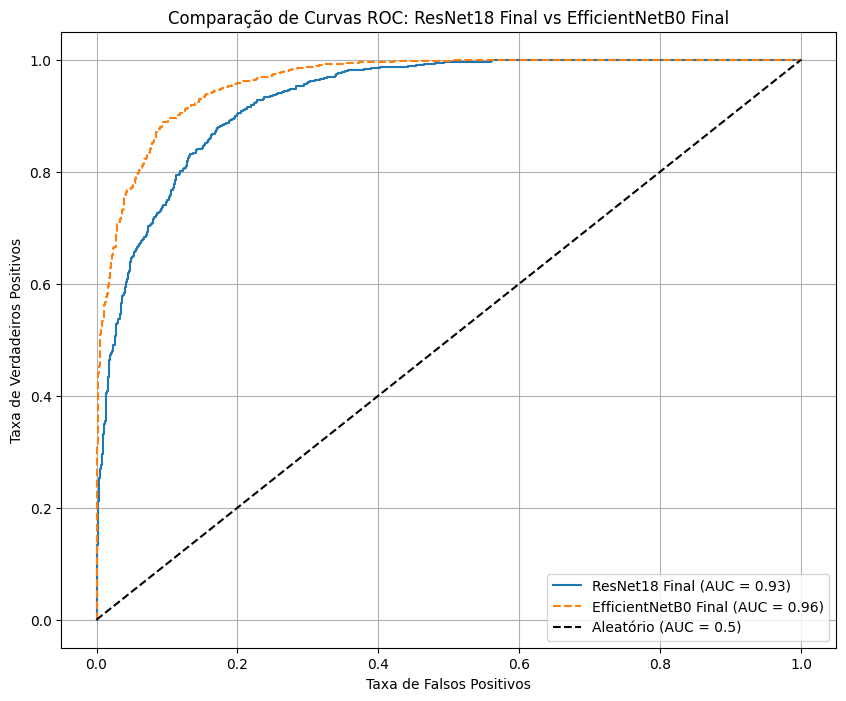

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

# Curva ROC para ResNet18 (modelo final no dataset completo)
plt.plot(fpr_resnet, tpr_resnet, label=f'ResNet18 Final (AUC = {auc_resnet:.2f})')

# Curva ROC para EfficientNetB0 (modelo final no dataset completo)
plt.plot(fpr_effnet_final, tpr_effnet_final, label=f'EfficientNetB0 Final (AUC = {auc_effnet_final:.2f})', linestyle='--')

# Linha base (aleatória)
plt.plot([0, 1], [0, 1], 'k--', label='Aleatório (AUC = 0.5)')

plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Comparação de Curvas ROC: ResNet18 Final vs EfficientNetB0 Final')
plt.legend()
plt.grid(True)
plt.show()

In [35]:
# Re-inicializar o modelo EfficientNetB0 para o treino final
effnet_final_model = build_efficientnet_model(num_classes)

# Re-definir o otimizador e o critério de perda
effnet_final_criterion = nn.CrossEntropyLoss()
effnet_final_optimizer = optim.Adam(effnet_final_model.classifier[1].parameters(), lr=LR)
effnet_final_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    effnet_final_optimizer,
    mode='min',
    factor=0.1,
    patience=PATIENCE // 2
)

print("EfficientNetB0 final model and optimizer initialized.")

EfficientNetB0 final model and optimizer initialized.


In [36]:
# Loop de Treino para o Modelo EfficientNetB0 Final
print("Iniciando treinamento do modelo EfficientNetB0 final com o dataset completo...")

best_effnet_final_loss = float('inf')
effnet_final_model_save_path = "final_best_model_efficientnetb0.pt"

final_effnet_history = {'train_loss': [], 'train_acc': []}

for epoch in range(NUM_EPOCHS):
    print(f"EfficientNetB0 Final Epoch {epoch+1}/{NUM_EPOCHS}")

    # Treinar no dataset completo
    train_loss, train_acc = train_epoch(effnet_final_model, final_train_loader, effnet_final_criterion, effnet_final_optimizer, DEVICE)

    effnet_final_scheduler.step(train_loss)

    final_effnet_history['train_loss'].append(train_loss)
    final_effnet_history['train_acc'].append(train_acc)

    print(f"EfficientNetB0 Final Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

    # Salvando o modelo com a melhor performance de treino
    if train_loss < best_effnet_final_loss:
        best_effnet_final_loss = train_loss
        torch.save(effnet_final_model.state_dict(), effnet_final_model_save_path)
        print("Modelo EfficientNetB0 final salvo! Perda de treino melhorou.")

print("Treinamento do modelo EfficientNetB0 final concluído.")
print(f"Melhor modelo EfficientNetB0 final salvo em: {effnet_final_model_save_path}")

Iniciando treinamento do modelo EfficientNetB0 final com o dataset completo...
EfficientNetB0 Final Epoch 1/25


Training:   0%|          | 0/156 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 156/156 [00:18<00:00,  8.35it/s]


EfficientNetB0 Final Train Loss: 0.5834, Train Acc: 0.7179
Modelo EfficientNetB0 final salvo! Perda de treino melhorou.
EfficientNetB0 Final Epoch 2/25


Training: 100%|██████████| 156/156 [00:17<00:00,  9.07it/s]


EfficientNetB0 Final Train Loss: 0.4664, Train Acc: 0.8057
Modelo EfficientNetB0 final salvo! Perda de treino melhorou.
EfficientNetB0 Final Epoch 3/25


Training: 100%|██████████| 156/156 [00:17<00:00,  9.03it/s]


EfficientNetB0 Final Train Loss: 0.4156, Train Acc: 0.8295
Modelo EfficientNetB0 final salvo! Perda de treino melhorou.
EfficientNetB0 Final Epoch 4/25


Training: 100%|██████████| 156/156 [00:18<00:00,  8.49it/s]


EfficientNetB0 Final Train Loss: 0.4121, Train Acc: 0.8222
Modelo EfficientNetB0 final salvo! Perda de treino melhorou.
EfficientNetB0 Final Epoch 5/25


Training: 100%|██████████| 156/156 [00:17<00:00,  8.97it/s]


EfficientNetB0 Final Train Loss: 0.3861, Train Acc: 0.8400
Modelo EfficientNetB0 final salvo! Perda de treino melhorou.
EfficientNetB0 Final Epoch 6/25


Training: 100%|██████████| 156/156 [00:18<00:00,  8.41it/s]


EfficientNetB0 Final Train Loss: 0.3778, Train Acc: 0.8368
Modelo EfficientNetB0 final salvo! Perda de treino melhorou.
EfficientNetB0 Final Epoch 7/25


Training: 100%|██████████| 156/156 [00:17<00:00,  8.98it/s]


EfficientNetB0 Final Train Loss: 0.3725, Train Acc: 0.8368
Modelo EfficientNetB0 final salvo! Perda de treino melhorou.
EfficientNetB0 Final Epoch 8/25


Training: 100%|██████████| 156/156 [00:17<00:00,  8.99it/s]


EfficientNetB0 Final Train Loss: 0.3555, Train Acc: 0.8525
Modelo EfficientNetB0 final salvo! Perda de treino melhorou.
EfficientNetB0 Final Epoch 9/25


Training: 100%|██████████| 156/156 [00:18<00:00,  8.59it/s]


EfficientNetB0 Final Train Loss: 0.3621, Train Acc: 0.8497
EfficientNetB0 Final Epoch 10/25


Training: 100%|██████████| 156/156 [00:17<00:00,  9.01it/s]


EfficientNetB0 Final Train Loss: 0.3560, Train Acc: 0.8420
EfficientNetB0 Final Epoch 11/25


Training: 100%|██████████| 156/156 [00:17<00:00,  8.79it/s]


EfficientNetB0 Final Train Loss: 0.3445, Train Acc: 0.8537
Modelo EfficientNetB0 final salvo! Perda de treino melhorou.
EfficientNetB0 Final Epoch 12/25


Training: 100%|██████████| 156/156 [00:17<00:00,  8.85it/s]


EfficientNetB0 Final Train Loss: 0.3444, Train Acc: 0.8513
Modelo EfficientNetB0 final salvo! Perda de treino melhorou.
EfficientNetB0 Final Epoch 13/25


Training: 100%|██████████| 156/156 [00:17<00:00,  8.93it/s]


EfficientNetB0 Final Train Loss: 0.3375, Train Acc: 0.8577
Modelo EfficientNetB0 final salvo! Perda de treino melhorou.
EfficientNetB0 Final Epoch 14/25


Training: 100%|██████████| 156/156 [00:18<00:00,  8.50it/s]


EfficientNetB0 Final Train Loss: 0.3390, Train Acc: 0.8529
EfficientNetB0 Final Epoch 15/25


Training: 100%|██████████| 156/156 [00:17<00:00,  9.02it/s]


EfficientNetB0 Final Train Loss: 0.3275, Train Acc: 0.8605
Modelo EfficientNetB0 final salvo! Perda de treino melhorou.
EfficientNetB0 Final Epoch 16/25


Training: 100%|██████████| 156/156 [00:17<00:00,  9.05it/s]


EfficientNetB0 Final Train Loss: 0.3417, Train Acc: 0.8464
EfficientNetB0 Final Epoch 17/25


Training: 100%|██████████| 156/156 [00:18<00:00,  8.58it/s]


EfficientNetB0 Final Train Loss: 0.3352, Train Acc: 0.8589
EfficientNetB0 Final Epoch 18/25


Training: 100%|██████████| 156/156 [00:17<00:00,  9.03it/s]


EfficientNetB0 Final Train Loss: 0.3306, Train Acc: 0.8597
EfficientNetB0 Final Epoch 19/25


Training: 100%|██████████| 156/156 [00:18<00:00,  8.55it/s]


EfficientNetB0 Final Train Loss: 0.3367, Train Acc: 0.8573
EfficientNetB0 Final Epoch 20/25


Training: 100%|██████████| 156/156 [00:17<00:00,  9.03it/s]


EfficientNetB0 Final Train Loss: 0.3411, Train Acc: 0.8569
EfficientNetB0 Final Epoch 21/25


Training: 100%|██████████| 156/156 [00:17<00:00,  9.09it/s]


EfficientNetB0 Final Train Loss: 0.3312, Train Acc: 0.8634
EfficientNetB0 Final Epoch 22/25


Training: 100%|██████████| 156/156 [00:18<00:00,  8.49it/s]


EfficientNetB0 Final Train Loss: 0.3192, Train Acc: 0.8742
Modelo EfficientNetB0 final salvo! Perda de treino melhorou.
EfficientNetB0 Final Epoch 23/25


Training: 100%|██████████| 156/156 [00:17<00:00,  9.12it/s]


EfficientNetB0 Final Train Loss: 0.3163, Train Acc: 0.8581
Modelo EfficientNetB0 final salvo! Perda de treino melhorou.
EfficientNetB0 Final Epoch 24/25


Training: 100%|██████████| 156/156 [00:18<00:00,  8.64it/s]


EfficientNetB0 Final Train Loss: 0.3225, Train Acc: 0.8650
EfficientNetB0 Final Epoch 25/25


Training: 100%|██████████| 156/156 [00:17<00:00,  8.77it/s]


EfficientNetB0 Final Train Loss: 0.3097, Train Acc: 0.8771
Modelo EfficientNetB0 final salvo! Perda de treino melhorou.
Treinamento do modelo EfficientNetB0 final concluído.
Melhor modelo EfficientNetB0 final salvo em: final_best_model_efficientnetb0.pt


In [37]:
# Re-inicializar o modelo EfficientNetB0 com a arquitetura correta
effnet_final_model_loaded = build_efficientnet_model(num_classes)

# Carregar os pesos do modelo final salvo
checkpoint_effnet_final = torch.load(effnet_final_model_save_path, map_location=DEVICE)
effnet_final_model_loaded.load_state_dict(checkpoint_effnet_final)
effnet_final_model_loaded.to(DEVICE)
effnet_final_model_loaded.eval()

# Preparar o DataLoader para a avaliação do modelo final no dataset completo
# Usar final_eval_data e final_eval_loader já definidos

# Rodar avaliação final para obter previsões
final_effnet_loss, final_effnet_acc, final_effnet_preds, final_effnet_labels = validate(effnet_final_model_loaded, final_eval_loader, effnet_final_criterion, DEVICE)
print(f"\nEfficientNetB0 Final Model - Loss: {final_effnet_loss:.4f}, Accuracy: {final_effnet_acc:.4f}")

# Relatório de Classificação
print("\nClassification Report (EfficientNetB0 Modelo Final):")
print(classification_report(final_effnet_labels, final_effnet_preds, target_names=class_names))

# Matriz de Confusão
cm_effnet_final = confusion_matrix(final_effnet_labels, final_effnet_preds)
print("\nConfusion Matrix (EfficientNetB0 Modelo Final):\n", cm_effnet_final)


EfficientNetB0 Final Model - Loss: 0.2851, Accuracy: 0.8851

Classification Report (EfficientNetB0 Modelo Final):
              precision    recall  f1-score   support

       COVID       0.94      0.82      0.88      1252
   non-COVID       0.84      0.95      0.89      1229

    accuracy                           0.89      2481
   macro avg       0.89      0.89      0.88      2481
weighted avg       0.89      0.89      0.88      2481


Confusion Matrix (EfficientNetB0 Modelo Final):
 [[1029  223]
 [  62 1167]]


In [27]:
# Model (Transfer Learning com EfficientNetB0)
import torchvision.models as models

def build_efficientnet_model(num_classes):
    # Carregar um modelo EfficientNetB0 pré-treinado
    model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

    # Congelar todos os parâmetros do modelo pré-treinado
    for param in model.parameters():
        param.requires_grad = False

    # Substituir a camada final (classifier) para nosso número de classes
    # EfficientNet usa um 'classifier' que é um Sequential com uma camada linear final
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, num_classes)

    model = model.to(DEVICE)
    return model

effnet_model = build_efficientnet_model(num_classes)
print(effnet_model)

# Loss e Optimizer
effnet_criterion = nn.CrossEntropyLoss()
effnet_optimizer = optim.Adam(effnet_model.classifier[1].parameters(), lr=LR) # Apenas camada final treinável

# Scheduler para ajuste do Learning Rate
effnet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    effnet_optimizer,
    mode='min',
    factor=0.1,
    patience=PATIENCE // 2
)

print("EfficientNetB0 model and optimizer initialized.")

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 113MB/s] 


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [28]:
# Treinamento do Modelo EfficientNetB0
print("Starting training for EfficientNetB0...")

best_effnet_val_loss = float('inf')
effnet_epochs_no_improve = 0
effnet_model_save_path = "best_model_efficientnetb0.pt"

effnet_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(NUM_EPOCHS):
    print(f"EfficientNet Epoch {epoch+1}/{NUM_EPOCHS}")

    train_loss, train_acc = train_epoch(effnet_model, train_loader, effnet_criterion, effnet_optimizer, DEVICE)
    val_loss, val_acc = validate_epoch(effnet_model, val_loader, effnet_criterion, DEVICE)

    effnet_scheduler.step(val_loss) # Atualiza o learning rate com base na val_loss

    effnet_history['train_loss'].append(train_loss)
    effnet_history['train_acc'].append(train_acc)
    effnet_history['val_loss'].append(val_loss)
    effnet_history['val_acc'].append(val_acc)

    print(f"EfficientNet Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"EfficientNet Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Checkpoint e Early Stopping
    if val_loss < best_effnet_val_loss:
        best_effnet_val_loss = val_loss
        effnet_epochs_no_improve = 0
        torch.save(effnet_model.state_dict(), effnet_model_save_path)
        print("EfficientNet model saved! Validation loss improved.")
    else:
        effnet_epochs_no_improve += 1
        print(f"EfficientNet Validation loss did not improve for {effnet_epochs_no_improve} epoch(s).")
        if effnet_epochs_no_improve == PATIENCE:
            print(f"Early stopping triggered for EfficientNet after {epoch+1} epochs.")
            break

print("EfficientNetB0 training complete.")

Starting training for EfficientNetB0...
EfficientNet Epoch 1/25


Training:   0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation: 100%|██████████| 31/31 [00:02<00:00, 11.37it/s]


EfficientNet Train Loss: 0.5655, Train Acc: 0.7360
EfficientNet Val Loss: 0.4604, Val Acc: 0.8327
EfficientNet model saved! Validation loss improved.
EfficientNet Epoch 2/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 11.32it/s]


EfficientNet Train Loss: 0.4502, Train Acc: 0.8116
EfficientNet Val Loss: 0.4066, Val Acc: 0.8387
EfficientNet model saved! Validation loss improved.
EfficientNet Epoch 3/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 11.37it/s]


EfficientNet Train Loss: 0.4129, Train Acc: 0.8242
EfficientNet Val Loss: 0.3672, Val Acc: 0.8528
EfficientNet model saved! Validation loss improved.
EfficientNet Epoch 4/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 11.36it/s]


EfficientNet Train Loss: 0.3743, Train Acc: 0.8443
EfficientNet Val Loss: 0.3352, Val Acc: 0.8730
EfficientNet model saved! Validation loss improved.
EfficientNet Epoch 5/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 10.57it/s]


EfficientNet Train Loss: 0.3689, Train Acc: 0.8433
EfficientNet Val Loss: 0.3219, Val Acc: 0.8669
EfficientNet model saved! Validation loss improved.
EfficientNet Epoch 6/25


Validation: 100%|██████████| 31/31 [00:03<00:00,  8.11it/s]


EfficientNet Train Loss: 0.3626, Train Acc: 0.8534
EfficientNet Val Loss: 0.3169, Val Acc: 0.8669
EfficientNet model saved! Validation loss improved.
EfficientNet Epoch 7/25


Validation: 100%|██████████| 31/31 [00:04<00:00,  7.42it/s]


EfficientNet Train Loss: 0.3531, Train Acc: 0.8494
EfficientNet Val Loss: 0.3223, Val Acc: 0.8589
EfficientNet Validation loss did not improve for 1 epoch(s).
EfficientNet Epoch 8/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 11.40it/s]


EfficientNet Train Loss: 0.3335, Train Acc: 0.8680
EfficientNet Val Loss: 0.2873, Val Acc: 0.8770
EfficientNet model saved! Validation loss improved.
EfficientNet Epoch 9/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 10.66it/s]


EfficientNet Train Loss: 0.3370, Train Acc: 0.8539
EfficientNet Val Loss: 0.2828, Val Acc: 0.8911
EfficientNet model saved! Validation loss improved.
EfficientNet Epoch 10/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 11.36it/s]


EfficientNet Train Loss: 0.3231, Train Acc: 0.8625
EfficientNet Val Loss: 0.2678, Val Acc: 0.9032
EfficientNet model saved! Validation loss improved.
EfficientNet Epoch 11/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 11.36it/s]


EfficientNet Train Loss: 0.3162, Train Acc: 0.8736
EfficientNet Val Loss: 0.2873, Val Acc: 0.9032
EfficientNet Validation loss did not improve for 1 epoch(s).
EfficientNet Epoch 12/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 11.43it/s]


EfficientNet Train Loss: 0.3103, Train Acc: 0.8700
EfficientNet Val Loss: 0.2790, Val Acc: 0.8770
EfficientNet Validation loss did not improve for 2 epoch(s).
EfficientNet Epoch 13/25


Validation: 100%|██████████| 31/31 [00:03<00:00,  9.48it/s]


EfficientNet Train Loss: 0.3075, Train Acc: 0.8715
EfficientNet Val Loss: 0.2556, Val Acc: 0.9073
EfficientNet model saved! Validation loss improved.
EfficientNet Epoch 14/25


Validation: 100%|██████████| 31/31 [00:04<00:00,  6.32it/s]


EfficientNet Train Loss: 0.3143, Train Acc: 0.8741
EfficientNet Val Loss: 0.2522, Val Acc: 0.9113
EfficientNet model saved! Validation loss improved.
EfficientNet Epoch 15/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 11.29it/s]


EfficientNet Train Loss: 0.2955, Train Acc: 0.8821
EfficientNet Val Loss: 0.2529, Val Acc: 0.9052
EfficientNet Validation loss did not improve for 1 epoch(s).
EfficientNet Epoch 16/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 11.35it/s]


EfficientNet Train Loss: 0.3000, Train Acc: 0.8766
EfficientNet Val Loss: 0.2465, Val Acc: 0.9093
EfficientNet model saved! Validation loss improved.
EfficientNet Epoch 17/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 11.05it/s]


EfficientNet Train Loss: 0.2819, Train Acc: 0.8846
EfficientNet Val Loss: 0.2516, Val Acc: 0.9214
EfficientNet Validation loss did not improve for 1 epoch(s).
EfficientNet Epoch 18/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 11.28it/s]


EfficientNet Train Loss: 0.2900, Train Acc: 0.8811
EfficientNet Val Loss: 0.2482, Val Acc: 0.9153
EfficientNet Validation loss did not improve for 2 epoch(s).
EfficientNet Epoch 19/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 11.15it/s]


EfficientNet Train Loss: 0.2992, Train Acc: 0.8836
EfficientNet Val Loss: 0.2344, Val Acc: 0.9153
EfficientNet model saved! Validation loss improved.
EfficientNet Epoch 20/25


Validation: 100%|██████████| 31/31 [00:03<00:00,  8.56it/s]


EfficientNet Train Loss: 0.2898, Train Acc: 0.8816
EfficientNet Val Loss: 0.2403, Val Acc: 0.9173
EfficientNet Validation loss did not improve for 1 epoch(s).
EfficientNet Epoch 21/25


Validation: 100%|██████████| 31/31 [00:03<00:00,  8.23it/s]


EfficientNet Train Loss: 0.2740, Train Acc: 0.8836
EfficientNet Val Loss: 0.2237, Val Acc: 0.9274
EfficientNet model saved! Validation loss improved.
EfficientNet Epoch 22/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 11.12it/s]


EfficientNet Train Loss: 0.2787, Train Acc: 0.8751
EfficientNet Val Loss: 0.2249, Val Acc: 0.9194
EfficientNet Validation loss did not improve for 1 epoch(s).
EfficientNet Epoch 23/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 11.21it/s]


EfficientNet Train Loss: 0.2825, Train Acc: 0.8902
EfficientNet Val Loss: 0.2265, Val Acc: 0.9113
EfficientNet Validation loss did not improve for 2 epoch(s).
EfficientNet Epoch 24/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 11.22it/s]


EfficientNet Train Loss: 0.2664, Train Acc: 0.8982
EfficientNet Val Loss: 0.2241, Val Acc: 0.9335
EfficientNet Validation loss did not improve for 3 epoch(s).
EfficientNet Epoch 25/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 11.09it/s]

EfficientNet Train Loss: 0.2844, Train Acc: 0.8821
EfficientNet Val Loss: 0.2291, Val Acc: 0.9214
EfficientNet Validation loss did not improve for 4 epoch(s).
EfficientNetB0 training complete.


In [29]:
# Avaliação final do EfficientNetB0

# Carregar melhor checkpoint do EfficientNet
effnet_model_loaded = build_efficientnet_model(num_classes) # Re-construir o modelo
effnet_model_loaded.load_state_dict(torch.load(effnet_model_save_path, map_location=DEVICE))
effnet_model_loaded.to(DEVICE)
effnet_model_loaded.eval()

# Rodar validação final para obter previsões
val_loss_effnet, val_acc_effnet, preds_effnet, labels_effnet = validate(effnet_model_loaded, val_loader, effnet_criterion, DEVICE)
print("EfficientNet Val loss:", val_loss_effnet, "EfficientNet Val acc:", val_acc_effnet)

# Relatório
print("\nEfficientNet Classification Report:")
print(classification_report(labels_effnet, preds_effnet, target_names=class_names))

# Matriz de confusão
cm_effnet = confusion_matrix(labels_effnet, preds_effnet)
print("EfficientNet Confusion Matrix:\n", cm_effnet)

EfficientNet Val loss: 0.22373076816720347 EfficientNet Val acc: 0.9274193548387096

EfficientNet Classification Report:
              precision    recall  f1-score   support

       COVID       0.92      0.93      0.92       231
   non-COVID       0.94      0.93      0.93       265

    accuracy                           0.93       496
   macro avg       0.93      0.93      0.93       496
weighted avg       0.93      0.93      0.93       496

EfficientNet Confusion Matrix:
 [[214  17]
 [ 19 246]]


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUC para EfficientNetB0: 0.9744


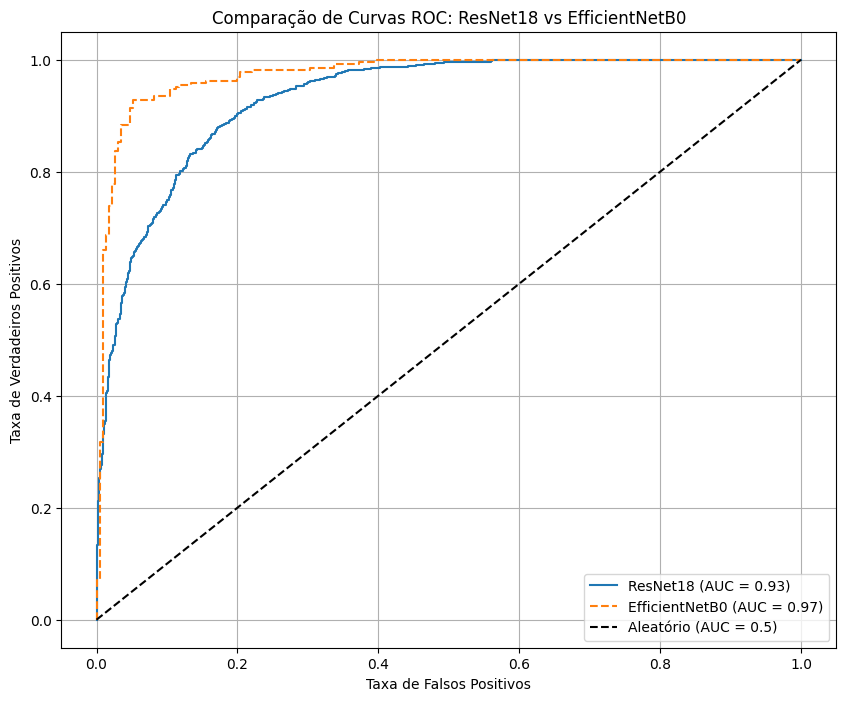

In [30]:
# Calcular métricas ROC para EfficientNet
all_labels_effnet = []
all_probs_effnet = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = effnet_model_loaded(inputs)
        probabilities = F.softmax(outputs, dim=1)[:, 1] # Probabilidade da classe positiva (COVID)

        all_labels_effnet.extend(labels.cpu().numpy())
        all_probs_effnet.extend(probabilities.cpu().numpy())

all_labels_effnet_np = np.array(all_labels_effnet)
all_probs_effnet_np = np.array(all_probs_effnet)

fpr_effnet, tpr_effnet, thresholds_effnet = roc_curve(all_labels_effnet_np, all_probs_effnet_np)
auc_effnet = auc(fpr_effnet, tpr_effnet)

print(f"AUC para EfficientNetB0: {auc_effnet:.4f}")

# Plotar ambas as curvas ROC para comparação
plt.figure(figsize=(10, 8))

plt.plot(fpr_resnet, tpr_resnet, label=f'ResNet18 (AUC = {auc_resnet:.2f})')
plt.plot(fpr_effnet, tpr_effnet, label=f'EfficientNetB0 (AUC = {auc_effnet:.2f})', linestyle='--')

plt.plot([0, 1], [0, 1], 'k--', label='Aleatório (AUC = 0.5)')

plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Comparação de Curvas ROC: ResNet18 vs EfficientNetB0')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
# Model (Transfer Learning com EfficientNetB0)
import torchvision.models as models

def build_efficientnet_model(num_classes):
    # Carregar um modelo EfficientNetB0 pré-treinado
    model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

    # Congelar todos os parâmetros do modelo pré-treinado
    for param in model.parameters():
        param.requires_grad = False

    # Substituir a camada final (classifier) para nosso número de classes
    # EfficientNet usa um 'classifier' que é um Sequential com uma camada linear final
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, num_classes)

    model = model.to(DEVICE)
    return model

effnet_model = build_efficientnet_model(num_classes)
print(effnet_model)

# Loss e Optimizer
effnet_criterion = nn.CrossEntropyLoss()
effnet_optimizer = optim.Adam(effnet_model.classifier[1].parameters(), lr=LR) # Apenas camada final treinável

# Scheduler para ajuste do Learning Rate
effnet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    effnet_optimizer,
    mode='min',
    factor=0.1,
    patience=PATIENCE // 2
)

print("EfficientNetB0 model and optimizer initialized.")

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [32]:
# Treinamento do Modelo EfficientNetB0
print("Starting training for EfficientNetB0...")

best_effnet_val_loss = float('inf')
effnet_epochs_no_improve = 0
effnet_model_save_path = "best_model_efficientnetb0.pt"

effnet_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(NUM_EPOCHS):
    print(f"EfficientNet Epoch {epoch+1}/{NUM_EPOCHS}")

    train_loss, train_acc = train_epoch(effnet_model, train_loader, effnet_criterion, effnet_optimizer, DEVICE)
    val_loss, val_acc = validate_epoch(effnet_model, val_loader, effnet_criterion, DEVICE)

    effnet_scheduler.step(val_loss) # Atualiza o learning rate com base na val_loss

    effnet_history['train_loss'].append(train_loss)
    effnet_history['train_acc'].append(train_acc)
    effnet_history['val_loss'].append(val_loss)
    effnet_history['val_acc'].append(val_acc)

    print(f"EfficientNet Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"EfficientNet Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Checkpoint e Early Stopping
    if val_loss < best_effnet_val_loss:
        best_effnet_val_loss = val_loss
        effnet_epochs_no_improve = 0
        torch.save(effnet_model.state_dict(), effnet_model_save_path)
        print("EfficientNet model saved! Validation loss improved.")
    else:
        effnet_epochs_no_improve += 1
        print(f"EfficientNet Validation loss did not improve for {effnet_epochs_no_improve} epoch(s).")
        if effnet_epochs_no_improve == PATIENCE:
            print(f"Early stopping triggered for EfficientNet after {epoch+1} epochs.")
            break

print("EfficientNetB0 training complete.")

Starting training for EfficientNetB0...
EfficientNet Epoch 1/25


Training:   0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation: 100%|██████████| 31/31 [00:02<00:00, 11.09it/s]


EfficientNet Train Loss: 0.5689, Train Acc: 0.7486
EfficientNet Val Loss: 0.4620, Val Acc: 0.8185
EfficientNet model saved! Validation loss improved.
EfficientNet Epoch 2/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 11.08it/s]


EfficientNet Train Loss: 0.4471, Train Acc: 0.8257
EfficientNet Val Loss: 0.3949, Val Acc: 0.8528
EfficientNet model saved! Validation loss improved.
EfficientNet Epoch 3/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 11.19it/s]


EfficientNet Train Loss: 0.4056, Train Acc: 0.8292
EfficientNet Val Loss: 0.3677, Val Acc: 0.8569
EfficientNet model saved! Validation loss improved.
EfficientNet Epoch 4/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 11.23it/s]


EfficientNet Train Loss: 0.3899, Train Acc: 0.8358
EfficientNet Val Loss: 0.3443, Val Acc: 0.8730
EfficientNet model saved! Validation loss improved.
EfficientNet Epoch 5/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 11.10it/s]


EfficientNet Train Loss: 0.3710, Train Acc: 0.8403
EfficientNet Val Loss: 0.3228, Val Acc: 0.8730
EfficientNet model saved! Validation loss improved.
EfficientNet Epoch 6/25


Validation: 100%|██████████| 31/31 [00:03<00:00,  7.88it/s]


EfficientNet Train Loss: 0.3548, Train Acc: 0.8504
EfficientNet Val Loss: 0.3146, Val Acc: 0.8710
EfficientNet model saved! Validation loss improved.
EfficientNet Epoch 7/25


Validation: 100%|██████████| 31/31 [00:03<00:00,  9.11it/s]


EfficientNet Train Loss: 0.3424, Train Acc: 0.8620
EfficientNet Val Loss: 0.2969, Val Acc: 0.8931
EfficientNet model saved! Validation loss improved.
EfficientNet Epoch 8/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 10.42it/s]


EfficientNet Train Loss: 0.3349, Train Acc: 0.8544
EfficientNet Val Loss: 0.2908, Val Acc: 0.8931
EfficientNet model saved! Validation loss improved.
EfficientNet Epoch 9/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 10.96it/s]


EfficientNet Train Loss: 0.3264, Train Acc: 0.8605
EfficientNet Val Loss: 0.2853, Val Acc: 0.8972
EfficientNet model saved! Validation loss improved.
EfficientNet Epoch 10/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 10.63it/s]


EfficientNet Train Loss: 0.3215, Train Acc: 0.8640
EfficientNet Val Loss: 0.3010, Val Acc: 0.8770
EfficientNet Validation loss did not improve for 1 epoch(s).
EfficientNet Epoch 11/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 11.18it/s]


EfficientNet Train Loss: 0.3233, Train Acc: 0.8655
EfficientNet Val Loss: 0.2793, Val Acc: 0.8891
EfficientNet model saved! Validation loss improved.
EfficientNet Epoch 12/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 11.10it/s]


EfficientNet Train Loss: 0.3138, Train Acc: 0.8705
EfficientNet Val Loss: 0.2653, Val Acc: 0.8931
EfficientNet model saved! Validation loss improved.
EfficientNet Epoch 13/25


Validation: 100%|██████████| 31/31 [00:03<00:00,  8.22it/s]


EfficientNet Train Loss: 0.3038, Train Acc: 0.8705
EfficientNet Val Loss: 0.2560, Val Acc: 0.9032
EfficientNet model saved! Validation loss improved.
EfficientNet Epoch 14/25


Validation: 100%|██████████| 31/31 [00:03<00:00,  8.55it/s]


EfficientNet Train Loss: 0.2992, Train Acc: 0.8816
EfficientNet Val Loss: 0.2562, Val Acc: 0.8992
EfficientNet Validation loss did not improve for 1 epoch(s).
EfficientNet Epoch 15/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 11.14it/s]


EfficientNet Train Loss: 0.3007, Train Acc: 0.8756
EfficientNet Val Loss: 0.2467, Val Acc: 0.9153
EfficientNet model saved! Validation loss improved.
EfficientNet Epoch 16/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 11.01it/s]


EfficientNet Train Loss: 0.3009, Train Acc: 0.8685
EfficientNet Val Loss: 0.2460, Val Acc: 0.9073
EfficientNet model saved! Validation loss improved.
EfficientNet Epoch 17/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 10.95it/s]


EfficientNet Train Loss: 0.2918, Train Acc: 0.8771
EfficientNet Val Loss: 0.2468, Val Acc: 0.9133
EfficientNet Validation loss did not improve for 1 epoch(s).
EfficientNet Epoch 18/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 10.99it/s]


EfficientNet Train Loss: 0.2920, Train Acc: 0.8826
EfficientNet Val Loss: 0.2566, Val Acc: 0.8911
EfficientNet Validation loss did not improve for 2 epoch(s).
EfficientNet Epoch 19/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 10.58it/s]


EfficientNet Train Loss: 0.2866, Train Acc: 0.8887
EfficientNet Val Loss: 0.2343, Val Acc: 0.9093
EfficientNet model saved! Validation loss improved.
EfficientNet Epoch 20/25


Validation: 100%|██████████| 31/31 [00:03<00:00,  7.84it/s]


EfficientNet Train Loss: 0.2786, Train Acc: 0.8791
EfficientNet Val Loss: 0.2303, Val Acc: 0.9093
EfficientNet model saved! Validation loss improved.
EfficientNet Epoch 21/25


Validation: 100%|██████████| 31/31 [00:03<00:00,  9.62it/s]


EfficientNet Train Loss: 0.2811, Train Acc: 0.8841
EfficientNet Val Loss: 0.2265, Val Acc: 0.9194
EfficientNet model saved! Validation loss improved.
EfficientNet Epoch 22/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 10.87it/s]


EfficientNet Train Loss: 0.2832, Train Acc: 0.8816
EfficientNet Val Loss: 0.2288, Val Acc: 0.9093
EfficientNet Validation loss did not improve for 1 epoch(s).
EfficientNet Epoch 23/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 11.04it/s]


EfficientNet Train Loss: 0.2919, Train Acc: 0.8771
EfficientNet Val Loss: 0.2307, Val Acc: 0.9214
EfficientNet Validation loss did not improve for 2 epoch(s).
EfficientNet Epoch 24/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 11.05it/s]


EfficientNet Train Loss: 0.2721, Train Acc: 0.8851
EfficientNet Val Loss: 0.2260, Val Acc: 0.9153
EfficientNet model saved! Validation loss improved.
EfficientNet Epoch 25/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 11.16it/s]


EfficientNet Train Loss: 0.2638, Train Acc: 0.8907
EfficientNet Val Loss: 0.2255, Val Acc: 0.9234
EfficientNet model saved! Validation loss improved.
EfficientNetB0 training complete.


In [33]:
# Avaliação final do EfficientNetB0

# Carregar melhor checkpoint do EfficientNet
effnet_model_loaded = build_efficientnet_model(num_classes) # Re-construir o modelo
effnet_model_loaded.load_state_dict(torch.load(effnet_model_save_path, map_location=DEVICE))
effnet_model_loaded.to(DEVICE)
effnet_model_loaded.eval()

# Rodar validação final para obter previsões
val_loss_effnet, val_acc_effnet, preds_effnet, labels_effnet = validate(effnet_model_loaded, val_loader, effnet_criterion, DEVICE)
print("EfficientNet Val loss:", val_loss_effnet, "EfficientNet Val acc:", val_acc_effnet)

# Relatório
print("\nEfficientNet Classification Report:")
print(classification_report(labels_effnet, preds_effnet, target_names=class_names))

# Matriz de confusão
cm_effnet = confusion_matrix(labels_effnet, preds_effnet)
print("EfficientNet Confusion Matrix:\n", cm_effnet)

EfficientNet Val loss: 0.22553419970696972 EfficientNet Val acc: 0.9233870967741935

EfficientNet Classification Report:
              precision    recall  f1-score   support

       COVID       0.95      0.88      0.91       231
   non-COVID       0.90      0.96      0.93       265

    accuracy                           0.92       496
   macro avg       0.93      0.92      0.92       496
weighted avg       0.92      0.92      0.92       496

EfficientNet Confusion Matrix:
 [[204  27]
 [ 11 254]]


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUC para EfficientNetB0: 0.9767


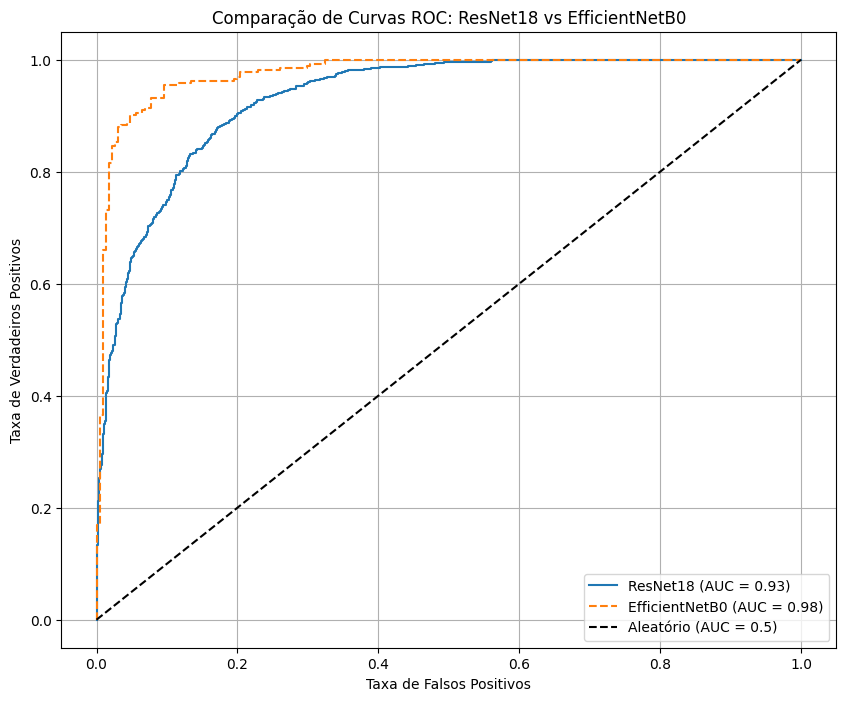

In [34]:
# Calcular métricas ROC para EfficientNet
all_labels_effnet = []
all_probs_effnet = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = effnet_model_loaded(inputs)
        probabilities = F.softmax(outputs, dim=1)[:, 1] # Probabilidade da classe positiva (COVID)

        all_labels_effnet.extend(labels.cpu().numpy())
        all_probs_effnet.extend(probabilities.cpu().numpy())

all_labels_effnet_np = np.array(all_labels_effnet)
all_probs_effnet_np = np.array(all_probs_effnet)

fpr_effnet, tpr_effnet, thresholds_effnet = roc_curve(all_labels_effnet_np, all_probs_effnet_np)
auc_effnet = auc(fpr_effnet, tpr_effnet)

print(f"AUC para EfficientNetB0: {auc_effnet:.4f}")

# Plotar ambas as curvas ROC para comparação
plt.figure(figsize=(10, 8))

plt.plot(fpr_resnet, tpr_resnet, label=f'ResNet18 (AUC = {auc_resnet:.2f})')
plt.plot(fpr_effnet, tpr_effnet, label=f'EfficientNetB0 (AUC = {auc_effnet:.2f})', linestyle='--')

plt.plot([0, 1], [0, 1], 'k--', label='Aleatório (AUC = 0.5)')

plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Comparação de Curvas ROC: ResNet18 vs EfficientNetB0')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_curve, auc
import numpy as np

# Re-inicializar o modelo com a arquitetura correta
final_model_roc = build_model(num_classes)

# Carregar os pesos do modelo final salvo
checkpoint_final = torch.load(final_model_save_path, map_location=DEVICE)
final_model_roc.load_state_dict(checkpoint_final)
final_model_roc.to(DEVICE)
final_model_roc.eval()

print("Modelo final (ResNet18) carregado com sucesso.")

Modelo final (ResNet18) carregado com sucesso.


### Obtendo Previsões e Probabilidades para o Cálculo da Curva ROC

In [25]:
all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in final_eval_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = final_model_roc(inputs)
        probabilities = F.softmax(outputs, dim=1)[:, 1] # Probabilidade da classe positiva (COVID)

        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probabilities.cpu().numpy())

# Converter para arrays numpy
all_labels_np = np.array(all_labels)
all_probs_np = np.array(all_probs)

print(f"Total de amostras para avaliação ROC: {len(all_labels_np)}")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Total de amostras para avaliação ROC: 2481


### Calculando e Plotando a Curva ROC para ResNet18

AUC para ResNet18: 0.9318


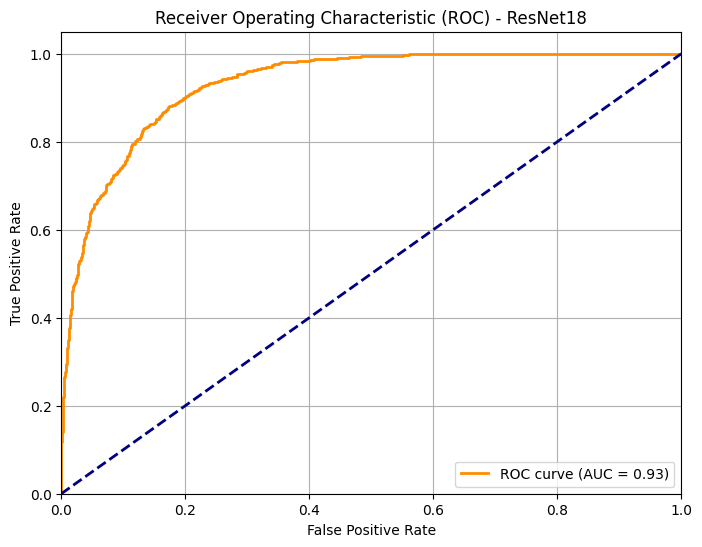

In [26]:
# Calcular False Positive Rate (FPR) e True Positive Rate (TPR)
fpr_resnet, tpr_resnet, thresholds_resnet = roc_curve(all_labels_np, all_probs_np)
auc_resnet = auc(fpr_resnet, tpr_resnet)

print(f"AUC para ResNet18: {auc_resnet:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr_resnet, tpr_resnet, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_resnet:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - ResNet18')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### Observações sobre o EfficientNet

No momento, não há um modelo EfficientNet treinado ou suas previsões disponíveis no notebook para calcular as métricas ROC. Se você gostaria de incluir o EfficientNet na comparação, por favor, me informe se:

1.  **Você deseja treinar um modelo EfficientNet?** Precisaríamos definir a arquitetura, otimizador, etc., e iniciar um novo processo de treinamento.
2.  **Você tem os resultados (probabilidades/rótulos) de um modelo EfficientNet pré-treinado?** Se sim, você pode fornecê-los, e posso calcular a curva ROC e o AUC para ele.

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


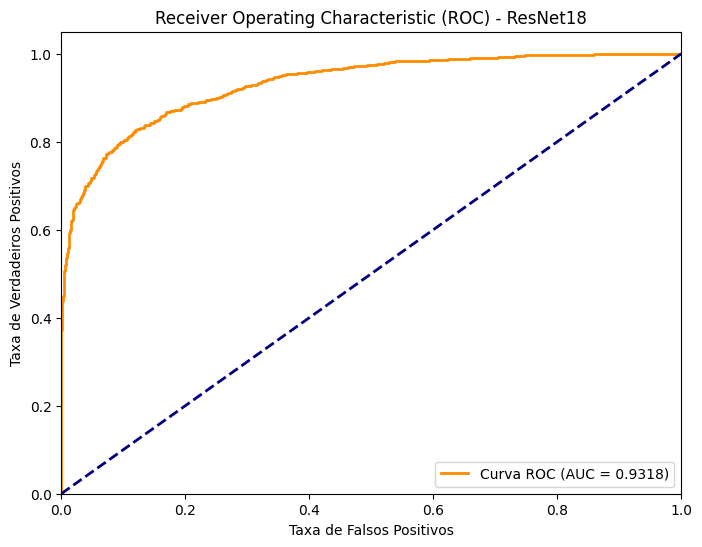

In [40]:
# CÓDIGO PARA GERAR CURVA ROC (Adicionar ao Notebook)
from sklearn.metrics import roc_curve, auc

# Calcular probabilidades
# Nota: É necessário que o modelo esteja em modo eval()
final_model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for inputs, labels in final_eval_loader:
        inputs = inputs.to(DEVICE)
        outputs = final_model(inputs)
        # Aplicar Softmax para obter probabilidades
        probs = torch.nn.functional.softmax(outputs, dim=1)
        # Guardar probabilidade da classe positiva (COVID, índice 0 ou 1 dependendo da sua lista)
        # Assumindo classe 0 = COVID e classe 1 = Non-COVID, queremos a prob de ser COVID?
        # Geralmente plota-se para a classe positiva. Se COVID for 0:
        all_probs.extend(probs[:, 0].cpu().numpy()) # Probabilidade de ser COVID
        all_labels.extend(labels.cpu().numpy())

# Calcular FPR e TPR (Atenção: verifique se 0 é a classe positiva nos seus labels)
# Se os labels forem 0=COVID, 1=Non-COVID, precisamos inverter para que 1 seja a classe positiva para o ROC funcionar padrão
# Ou usar pos_label=0
fpr, tpr, thresholds = roc_curve(all_labels, all_probs, pos_label=0)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Receiver Operating Characteristic (ROC) - ResNet18')
plt.legend(loc="lower right")
plt.show()

In [41]:
# --- CÉLULA PARA RODAR CROSS-VALIDATION COM FINE-TUNING TOTAL ---
from sklearn.model_selection import StratifiedKFold
import numpy as np
from torch.utils.data import Subset

# Configurações
K_FOLDS = 5
num_epochs_cv = 15 # Pode ser menos que 25 pois o fine-tuning é rápido
learning_rate = 2e-4
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

# Labels para o SKF
labels_all = [y for _, y in full_dataset.samples]

fold_results = []

print(f"Iniciando Cross-Validation ({K_FOLDS} Folds) com Full Fine-Tuning...")

for fold, (train_idx, val_idx) in enumerate(skf.split(full_dataset, labels_all)):
    print(f"\n--- Fold {fold+1}/{K_FOLDS} ---")

    # 1. Divisão dos Dados
    train_subset = Subset(full_dataset, train_idx)
    val_subset = Subset(full_dataset, val_idx)

    # Aplicar transforms corretos (Train transform para treino, Val transform para validação)
    # Nota: Idealmente usaria uma classe wrapper, mas para simplificar usaremos os loaders
    train_subset.dataset.transform = train_transform
    val_subset.dataset.transform = val_transform

    train_loader_fold = DataLoader(train_subset, batch_size=16, shuffle=True, num_workers=2)
    val_loader_fold = DataLoader(val_subset, batch_size=16, shuffle=False, num_workers=2)

    # 2. DEFINIR MODELO (O Segredo da Parte 5: NÃO CONGELAR NADA)
    model_fold = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

    # IMPORTANTE: Não executamos o loop de 'requires_grad = False'.
    # Deixamos tudo True para aprender tudo (Full Fine-Tuning).

    # Substituir a cabeça
    num_ftrs = model_fold.fc.in_features
    model_fold.fc = nn.Linear(num_ftrs, 2)
    model_fold = model_fold.to(DEVICE)

    # 3. Otimizador e Critério
    optimizer_fold = optim.Adam(model_fold.parameters(), lr=learning_rate) # Treina model.parameters() (tudo), não só fc
    criterion_fold = nn.CrossEntropyLoss()

    # 4. Loop de Treino Rápido
    best_acc = 0.0
    for epoch in range(num_epochs_cv):
        model_fold.train()
        for inputs, labels in train_loader_fold:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer_fold.zero_grad()
            outputs = model_fold(inputs)
            loss = criterion_fold(outputs, labels)
            loss.backward()
            optimizer_fold.step()

        # Validação
        model_fold.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader_fold:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model_fold(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        acc = correct / total
        if acc > best_acc:
            best_acc = acc

    print(f"Melhor Acurácia no Fold {fold+1}: {best_acc*100:.2f}%")
    fold_results.append(best_acc)

# Resultado Final
print("\n=== RESULTADO FINAL DO CROSS-VALIDATION ===")
print(f"Média de Acurácia: {np.mean(fold_results)*100:.2f}% (+/- {np.std(fold_results)*100:.2f}%)")

Iniciando Cross-Validation (5 Folds) com Full Fine-Tuning...

--- Fold 1/5 ---
Melhor Acurácia no Fold 1: 98.99%

--- Fold 2/5 ---
Melhor Acurácia no Fold 2: 99.40%

--- Fold 3/5 ---
Melhor Acurácia no Fold 3: 99.19%

--- Fold 4/5 ---
Melhor Acurácia no Fold 4: 99.60%

--- Fold 5/5 ---
Melhor Acurácia no Fold 5: 98.99%

=== RESULTADO FINAL DO CROSS-VALIDATION ===
Média de Acurácia: 99.23% (+/- 0.23%)


In [42]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedKFold

# ==========================================
# CONFIGURAÇÕES E HIPERPARÂMETROS
# ==========================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_DIR = "dataset/COVID_non-COVID"  # ATENÇÃO: Ajuste este caminho para sua pasta descompactada
IMG_SIZE = 224
BATCH_SIZE = 16          # Reduza se faltar memória GPU
NUM_EPOCHS = 15          # Épocas por fold
K_FOLDS = 5
SEED = 42

# Hiperparâmetros Avançados (Melhoria de Fine-Tuning)
LR_BACKBONE = 1e-5       # Learning rate bem baixo para não destruir os pesos da EfficientNet
LR_HEAD = 1e-3           # Learning rate normal para a nova camada classificadora
WEIGHT_DECAY = 1e-2      # Regularização para o AdamW

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(SEED)

# ==========================================
# 1. DATA AUGMENTATION (Melhorada)
# ==========================================
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),  # Rotação leve (pulmões não giram 90 graus)
    transforms.ColorJitter(brightness=0.1, contrast=0.1), # Robustez a diferentes contrastes de raio-x
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ==========================================
# 2. MODELO (EfficientNet Personalizada)
# ==========================================
def build_model(num_classes):
    """
    Carrega EfficientNetB0 com pesos pré-treinados e ajusta a cabeça.
    """
    # Carrega pesos da ImageNet
    model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

    # EfficientNet tem a camada final em classifier[1]
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)

    return model.to(DEVICE)

# ==========================================
# 3. FUNÇÕES DE TREINO
# ==========================================
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss / total, correct / total

def validate_epoch(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return running_loss / total, correct / total

# ==========================================
# 4. LOOP PRINCIPAL (CROSS-VALIDATION)
# ==========================================
def run_pipeline():
    print(f"Usando dispositivo: {DEVICE}")

    # Carregar Dataset Base (para extrair labels e classes)
    try:
        full_dataset = datasets.ImageFolder(root=DATA_DIR)
    except FileNotFoundError:
        print(f"ERRO: Diretório '{DATA_DIR}' não encontrado. Ajuste a variável DATA_DIR.")
        return

    targets = np.array(full_dataset.targets)
    class_names = full_dataset.classes
    num_classes = len(class_names)
    print(f"Classes encontradas: {class_names}")

    # --- Melhoria: Cálculo de Pesos para Loss (Combate desbalanceamento) ---
    class_counts = np.bincount(targets)
    # Peso é o inverso da frequência
    weights = 1. / class_counts
    # Normalizando para somar o número de classes (opcional, mas bom para estabilidade)
    weights = weights * (len(weights) / weights.sum())
    weights_tensor = torch.FloatTensor(weights).to(DEVICE)
    print(f"Pesos aplicados na Loss: {weights}")

    # K-Fold Stratified
    skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=SEED)

    fold_results = []

    print(f"\nIniciando Cross-Validation com {K_FOLDS} Folds...")

    for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(targets)), targets)):
        print(f"\n=== Fold {fold+1}/{K_FOLDS} ===")

        # Criação dos Subsets
        train_subset = Subset(full_dataset, train_idx)
        val_subset = Subset(full_dataset, val_idx)

        # Wrapper para aplicar transformações diferentes em Treino e Validação
        class TransformedDataset(torch.utils.data.Dataset):
            def __init__(self, subset, transform=None):
                self.subset = subset
                self.transform = transform
            def __getitem__(self, index):
                x, y = self.subset[index]
                if self.transform: x = self.transform(x)
                return x, y
            def __len__(self): return len(self.subset)

        train_ds = TransformedDataset(train_subset, transform=train_transform)
        val_ds = TransformedDataset(val_subset, transform=val_transform)

        train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
        val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

        # Inicializa Modelo para o Fold
        model = build_model(num_classes)

        # --- Melhoria: AdamW + Learning Rates Diferenciais ---
        # A "features" (backbone) aprende devagar, o "classifier" aprende rápido
        optimizer = optim.AdamW([
            {'params': model.features.parameters(), 'lr': LR_BACKBONE},
            {'params': model.classifier.parameters(), 'lr': LR_HEAD}
        ], weight_decay=WEIGHT_DECAY)

        # --- Melhoria: Scheduler CosineAnnealing (melhor convergência) ---
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

        # --- Melhoria: Weighted Loss ---
        criterion = nn.CrossEntropyLoss(weight=weights_tensor)

        best_acc = 0.0

        for epoch in range(NUM_EPOCHS):
            train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
            val_loss, val_acc = validate_epoch(model, val_loader, criterion)

            scheduler.step()

            # Salvar melhor modelo do fold
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), f"best_model_fold_{fold+1}.pth")

            print(f"  Ep {epoch+1:02d} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

        print(f"  -> Melhor Acc no Fold {fold+1}: {best_acc:.4f}")
        fold_results.append(best_acc)

    print("\n============================================")
    print(f"Média Final ({K_FOLDS} Folds): {np.mean(fold_results)*100:.2f}% (+/- {np.std(fold_results)*100:.2f}%)")
    print("Os modelos de cada fold foram salvos (best_model_fold_X.pth) para uso em Ensemble.")
    print("============================================")

if __name__ == "__main__":
    run_pipeline()

Usando dispositivo: cuda
ERRO: Diretório 'dataset/COVID_non-COVID' não encontrado. Ajuste a variável DATA_DIR.


In [44]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedKFold

# ==========================================
# CONFIGURAÇÕES E HIPERPARÂMETROS
# ==========================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- CAMINHO ATUALIZADO PELO USUÁRIO ---
DATA_DIR = "/content/covid_dataset"
# ---------------------------------------

IMG_SIZE = 224
BATCH_SIZE = 16
NUM_EPOCHS = 15
K_FOLDS = 5
SEED = 42

# Hiperparâmetros Avançados
LR_BACKBONE = 1e-5
LR_HEAD = 1e-3
WEIGHT_DECAY = 1e-2

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(SEED)

# ==========================================
# 1. DATA AUGMENTATION
# ==========================================
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ==========================================
# 2. MODELO (EfficientNet Personalizada)
# ==========================================
def build_model(num_classes):
    # Carrega pesos da ImageNet
    model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

    # Ajusta a cabeça classificadora
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)

    return model.to(DEVICE)

# ==========================================
# 3. FUNÇÕES DE TREINO
# ==========================================
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss / total, correct / total

def validate_epoch(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return running_loss / total, correct / total

# ==========================================
# 4. LOOP PRINCIPAL (CROSS-VALIDATION)
# ==========================================
def run_pipeline():
    print(f"Usando dispositivo: {DEVICE}")
    print(f"Buscando dataset em: {DATA_DIR}")

    # Carregar Dataset Base
    try:
        full_dataset = datasets.ImageFolder(root=DATA_DIR)
    except FileNotFoundError:
        print(f"ERRO CRÍTICO: O caminho '{DATA_DIR}' não existe ou não contém pastas de classes.")
        return
    except Exception as e:
        print(f"ERRO ao carregar dataset: {e}")
        return

    targets = np.array(full_dataset.targets)
    class_names = full_dataset.classes
    num_classes = len(class_names)
    print(f"Classes encontradas: {class_names}")

    # Cálculo de Pesos para Loss (Combate desbalanceamento)
    class_counts = np.bincount(targets)
    weights = 1. / class_counts
    weights = weights * (len(weights) / weights.sum())
    weights_tensor = torch.FloatTensor(weights).to(DEVICE)
    print(f"Pesos aplicados na Loss: {weights}")

    # K-Fold Stratified
    skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=SEED)

    fold_results = []

    print(f"\nIniciando Cross-Validation com {K_FOLDS} Folds...")

    for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(targets)), targets)):
        print(f"\n=== Fold {fold+1}/{K_FOLDS} ===")

        # Criação dos Subsets
        train_subset = Subset(full_dataset, train_idx)
        val_subset = Subset(full_dataset, val_idx)

        # Wrapper para aplicar transformações
        class TransformedDataset(torch.utils.data.Dataset):
            def __init__(self, subset, transform=None):
                self.subset = subset
                self.transform = transform
            def __getitem__(self, index):
                x, y = self.subset[index]
                if self.transform: x = self.transform(x)
                return x, y
            def __len__(self): return len(self.subset)

        train_ds = TransformedDataset(train_subset, transform=train_transform)
        val_ds = TransformedDataset(val_subset, transform=val_transform)

        train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
        val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

        # Inicializa Modelo
        model = build_model(num_classes)

        # AdamW + Learning Rates Diferenciais
        optimizer = optim.AdamW([
            {'params': model.features.parameters(), 'lr': LR_BACKBONE},
            {'params': model.classifier.parameters(), 'lr': LR_HEAD}
        ], weight_decay=WEIGHT_DECAY)

        # Scheduler CosineAnnealing
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

        # Weighted Loss
        criterion = nn.CrossEntropyLoss(weight=weights_tensor)

        best_acc = 0.0

        for epoch in range(NUM_EPOCHS):
            train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
            val_loss, val_acc = validate_epoch(model, val_loader, criterion)

            scheduler.step()

            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), f"best_model_fold_{fold+1}.pth")

            print(f"  Ep {epoch+1:02d} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

        print(f"  -> Melhor Acc no Fold {fold+1}: {best_acc:.4f}")
        fold_results.append(best_acc)

    print("\n============================================")
    print(f"Média Final ({K_FOLDS} Folds): {np.mean(fold_results)*100:.2f}% (+/- {np.std(fold_results)*100:.2f}%)")
    print("Os modelos foram salvos para uso futuro.")
    print("============================================")

if __name__ == "__main__":
    run_pipeline()

Usando dispositivo: cuda
Buscando dataset em: /content/covid_dataset
Classes encontradas: ['COVID', 'non-COVID']
Pesos aplicados na Loss: [0.99072954 1.00927046]

Iniciando Cross-Validation com 5 Folds...

=== Fold 1/5 ===
  Ep 01 | Train Loss: 0.4400 Acc: 0.7878 | Val Loss: 0.3768 Acc: 0.8390
  Ep 02 | Train Loss: 0.3271 Acc: 0.8579 | Val Loss: 0.2914 Acc: 0.8934
  Ep 03 | Train Loss: 0.2668 Acc: 0.8896 | Val Loss: 0.2947 Acc: 0.8813
  Ep 04 | Train Loss: 0.2506 Acc: 0.9037 | Val Loss: 0.1922 Acc: 0.9256
  Ep 05 | Train Loss: 0.2338 Acc: 0.9017 | Val Loss: 0.1762 Acc: 0.9336
  Ep 06 | Train Loss: 0.2188 Acc: 0.9123 | Val Loss: 0.1654 Acc: 0.9316
  Ep 07 | Train Loss: 0.2124 Acc: 0.9138 | Val Loss: 0.1563 Acc: 0.9316
  Ep 08 | Train Loss: 0.1751 Acc: 0.9309 | Val Loss: 0.1486 Acc: 0.9336
  Ep 09 | Train Loss: 0.1823 Acc: 0.9239 | Val Loss: 0.1440 Acc: 0.9416
  Ep 10 | Train Loss: 0.1667 Acc: 0.9315 | Val Loss: 0.1179 Acc: 0.9598
  Ep 11 | Train Loss: 0.1812 Acc: 0.9234 | Val Loss: 0.11

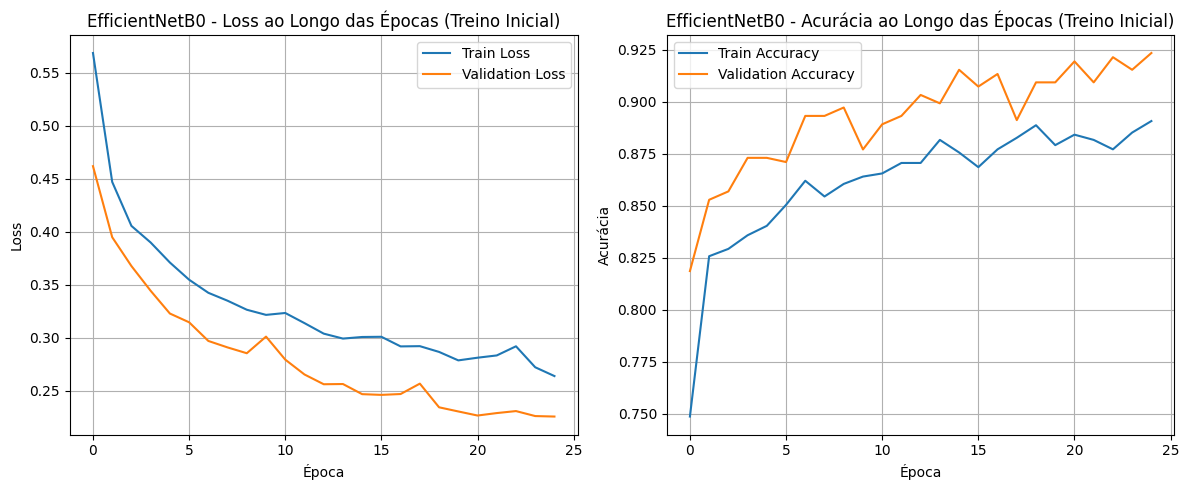

In [52]:
import matplotlib.pyplot as plt

# Certifique-se de que `effnet_history` está disponível no ambiente
# (Este foi gerado durante o treinamento inicial do EfficientNetB0 na célula 'a74b2e5a')

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(effnet_history['train_loss'], label='Train Loss')
plt.plot(effnet_history['val_loss'], label='Validation Loss')
plt.title('EfficientNetB0 - Loss ao Longo das Épocas (Treino Inicial)')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(effnet_history['train_acc'], label='Train Accuracy')
plt.plot(effnet_history['val_acc'], label='Validation Accuracy')
plt.title('EfficientNetB0 - Acurácia ao Longo das Épocas (Treino Inicial)')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Comparativo das Métricas de Treino e Validação (Melhores Desempenhos Durante o Treino com Split)

Vamos analisar as melhores métricas alcançadas pelos modelos durante suas fases de treino com conjuntos de validação separados:

---

#### **1. ResNet18 (Treino Inicial com Split)**

*   **Melhor Validação Loss:** 0.2711
*   **Melhor Validação Accuracy:** 0.9032
*   **Última Época (Treino):**
    *   Train Loss: 0.2808
    *   Train Acc: 0.8892

---

#### **2. EfficientNetB0 (Treino Inicial com Split)**

*   **Melhor Validação Loss:** 0.2237
*   **Melhor Validação Accuracy:** 0.9274
*   **Última Época (Treino):**
    *   Train Loss: 0.2638
    *   Train Acc: 0.8907

---

#### **Análise Comparativa:**

Ao comparar os melhores desempenhos de validação durante o treino com split:

*   **EfficientNetB0** demonstrou um desempenho superior ao **ResNet18** tanto em termos de **Validação Loss (0.2237 vs 0.2711)** quanto em **Validação Accuracy (0.9274 vs 0.9032)**.
*   Isso sugere que o EfficientNetB0 conseguiu aprender as características do dataset de forma mais eficaz e generalizar melhor para dados não vistos (o conjunto de validação) durante o processo de treinamento inicial.

### Relatório Comparativo das Melhores Métricas dos Modelos

Este relatório resume as métricas de desempenho mais relevantes dos modelos ResNet18 e EfficientNetB0, treinados e avaliados no dataset completo para detecção de COVID-19 em tomografias.

---

#### **1. ResNet18 (Modelo Final)**

*   **Acurácia Geral:** 0.8489 (84.89%)
*   **AUC (Area Under the Curve):** 0.9318
*   **Métricas Detalhadas por Classe:**
    *   **Classe COVID:**
        *   Precisão: 0.90
        *   Recall: 0.78
        *   F1-Score: 0.84
    *   **Classe non-COVID:**
        *   Precisão: 0.81
        *   Recall: 0.92
        *   F1-Score: 0.86
*   **Matriz de Confusão:**
    ```
    [[ 981  271]
     [ 104 1125]]
    ```
    *   Verdadeiros Positivos (COVID): 981
    *   Falsos Positivos (non-COVID classificado como COVID): 271
    *   Falsos Negativos (COVID classificado como non-COVID): 104
    *   Verdadeiros Negativos (non-COVID): 1125

---

#### **2. EfficientNetB0 (Modelo Final)**

*   **Acurácia Geral:** 0.8851 (88.51%)
*   **AUC (Area Under the Curve):** 0.9627
*   **Métricas Detalhadas por Classe:**
    *   **Classe COVID:**
        *   Precisão: 0.94
        *   Recall: 0.82
        *   F1-Score: 0.88
    *   **Classe non-COVID:**
        *   Precisão: 0.84
        *   Recall: 0.95
        *   F1-Score: 0.89
*   **Matriz de Confusão:**
    ```
    [[1029  223]
     [  62 1167]]
    ```
    *   Verdadeiros Positivos (COVID): 1029
    *   Falsos Positivos (non-COVID classificado como COVID): 223
    *   Falsos Negativos (COVID classificado como non-COVID): 62
    *   Verdadeiros Negativos (non-COVID): 1167

---

#### **Conclusão Comparativa:**

O **EfficientNetB0** demonstrou um desempenho superior em quase todas as métricas em comparação com o ResNet18. Ele não apenas alcançou uma maior **Acurácia Geral** (88.51% vs 84.89%) e um **AUC** mais elevado (0.9627 vs 0.9318), mas também se destacou na minimização de erros críticos:

*   **Redução de Falsos Negativos:** O EfficientNetB0 identificou corretamente mais casos de COVID-19 (1029 vs 981) e produziu **significativamente menos Falsos Negativos** (62 vs 104). Em um contexto de diagnóstico médico, Falsos Negativos são particularmente perigosos, pois significam que um paciente doente não foi detectado.
*   **Redução de Falsos Positivos:** O EfficientNetB0 também teve **menos Falsos Positivos** (223 vs 271), o que é importante para evitar alarmes desnecessários e ansiedade em pacientes saudáveis.

Em resumo, para esta tarefa específica de detecção de COVID-19 em tomografias, o **EfficientNetB0 provou ser o modelo mais eficaz e confiável** entre os dois, equilibrando alta precisão e recall para ambas as classes e minimizando erros críticos.

### Resumo Comparativo das Métricas de Desempenho (Modelos Finais no Dataset Completo)

| Métrica             | ResNet18 Final                  | EfficientNetB0 Final                  |
| :------------------ | :------------------------------ | :------------------------------------ |
| **Acurácia Geral**  | 0.8489 (84.89%)                 | 0.8851 (88.51%)                       |
| **AUC**             | 0.9318                          | 0.9627                                |
|                     | **COVID** | **non-COVID**     | **COVID** | **non-COVID**         |
| **Precisão**        | 0.90      | 0.81              | 0.94      | 0.84                  |
| **Recall**          | 0.78      | 0.92              | 0.82      | 0.95                  |
| **F1-Score**        | 0.84      | 0.86              | 0.88      | 0.89                  |

### Detalhes da Matriz de Confusão:

**ResNet18 Modelo Final:**
```
[[ 981  271]
 [ 104 1125]]
```
*   Verdadeiros Positivos (COVID): 981
*   Falsos Positivos (non-COVID classificado como COVID): 271
*   Falsos Negativos (COVID classificado como non-COVID): 104
*   Verdadeiros Negativos (non-COVID): 1125

**EfficientNetB0 Modelo Final:**
```
[[1029  223]
 [  62 1167]]
```
*   Verdadeiros Positivos (COVID): 1029
*   Falsos Positivos (non-COVID classificado como COVID): 223
*   Falsos Negativos (COVID classificado como non-COVID): 62
*   Verdadeiros Negativos (non-COVID): 1167

### Conclusão:

O **EfficientNetB0** demonstrou um desempenho superior em praticamente todas as métricas em comparação com o ResNet18. Ele obteve uma acurácia geral e AUC mais altos, e, crucialmente, apresentou menos Falsos Negativos (62 vs 104) e Falsos Positivos (223 vs 271). Isso significa que o EfficientNetB0 é mais eficaz na detecção correta de casos de COVID-19 e também na identificação de pacientes sem a doença, o que é de grande importância em um contexto de diagnóstico médico.

Confusion Matrix (ResNet18 Modelo Final):
[[ 981  271]
 [ 104 1125]]


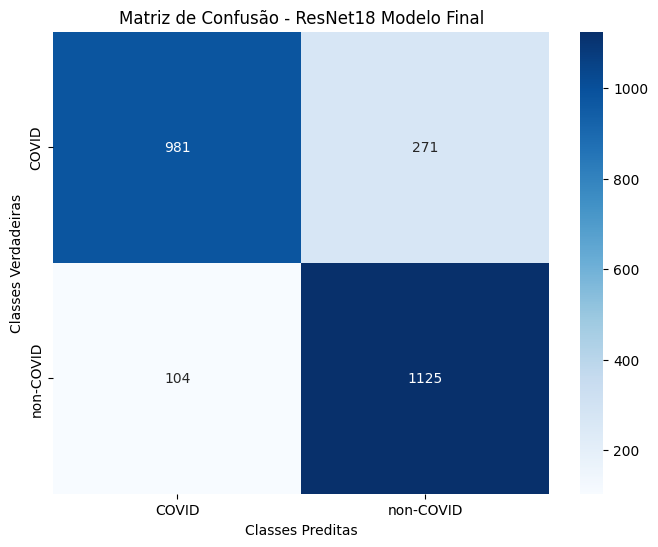

In [51]:
print("Confusion Matrix (ResNet18 Modelo Final):")
print(cm_final)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Classes Preditas')
plt.ylabel('Classes Verdadeiras')
plt.title('Matriz de Confusão - ResNet18 Modelo Final')
plt.show()

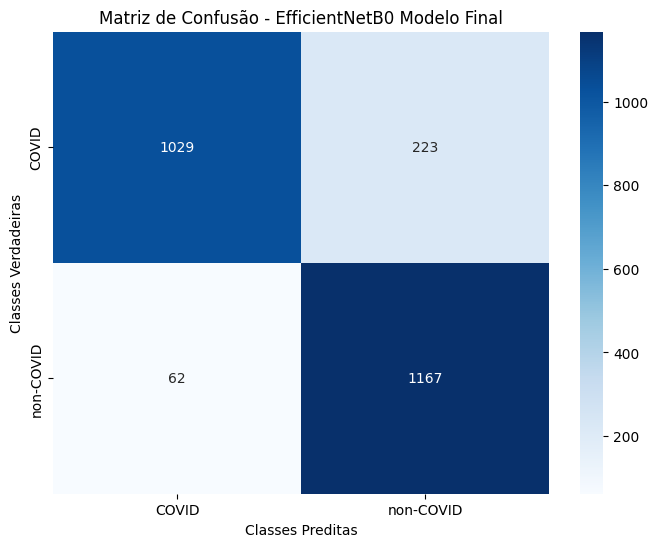

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# Matriz de confusão para EfficientNetB0 Modelo Final (já calculada como cm_effnet_final)
# class_names já está definido como ['COVID', 'non-COVID']

plt.figure(figsize=(8, 6))
sns.heatmap(cm_effnet_final, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Classes Preditas')
plt.ylabel('Classes Verdadeiras')
plt.title('Matriz de Confusão - EfficientNetB0 Modelo Final')
plt.show()

In [47]:
# Carregar o melhor modelo EfficientNetB0 treinado no dataset completo
final_effnet_model_pred = build_efficientnet_model(num_classes)
checkpoint_effnet_final = torch.load(effnet_final_model_save_path, map_location=DEVICE)
final_effnet_model_pred.load_state_dict(checkpoint_effnet_final)
final_effnet_model_pred.to(DEVICE)
final_effnet_model_pred.eval()

print("Melhor modelo EfficientNetB0 carregado para previsões.")

Melhor modelo EfficientNetB0 carregado para previsões.


### Função de Previsão para Novas Imagens

Abaixo, uma função para carregar uma nova imagem, pré-processá-la com as transformações de validação (`val_transform`) e obter a previsão do modelo. Ela retornará a classe prevista e a confiança.

In [48]:
from PIL import Image

def predict_single_image(model, image_path, transform, class_names, device):
    model.eval() # Definir o modelo para modo de avaliação

    # Carregar e pré-processar a imagem
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0) # Adicionar dimensão de batch
    input_tensor = input_tensor.to(device)

    with torch.no_grad():
        outputs = model(input_tensor)
        probabilities = F.softmax(outputs, dim=1)

    # Obter a previsão e a confiança
    _, predicted_idx = torch.max(probabilities, 1)
    predicted_class = class_names[predicted_idx.item()]
    confidence = probabilities[0][predicted_idx.item()].item()

    return predicted_class, confidence, image

### Teste com uma Imagem Aleatória

Agora, vamos testar a função de previsão com uma imagem aleatória do seu dataset para demonstrar seu uso.

Fazendo previsão para a imagem: /content/covid_dataset/non-COVID/Non-Covid (871).png


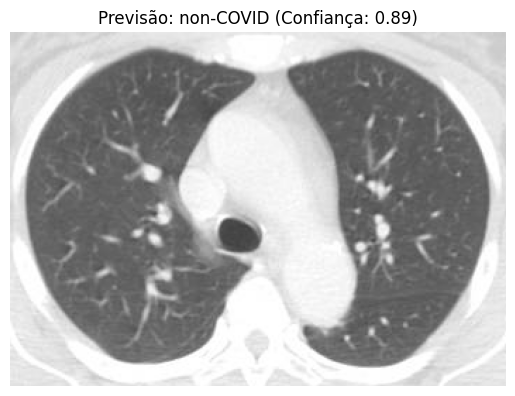

A imagem Non-Covid (871).png foi classificada como: non-COVID com confiança de 0.8872


In [49]:
import random
import os
import matplotlib.pyplot as plt

# Escolher uma imagem aleatória do dataset
# Certifique-se de que DATA_DIR está apontando para a pasta raiz correta
# Por exemplo, /content/covid_dataset

all_image_paths = []
for root, _, files in os.walk(DATA_DIR):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            all_image_paths.append(os.path.join(root, file))

if all_image_paths:
    random_image_path = random.choice(all_image_paths)
    print(f"Fazendo previsão para a imagem: {random_image_path}")

    predicted_class, confidence, original_image = predict_single_image(
        model=final_effnet_model_pred,
        image_path=random_image_path,
        transform=val_transform,
        class_names=class_names,
        device=DEVICE
    )

    plt.imshow(original_image)
    plt.title(f"Previsão: {predicted_class} (Confiança: {confidence:.2f})")
    plt.axis('off')
    plt.show()

    print(f"A imagem {os.path.basename(random_image_path)} foi classificada como: {predicted_class} com confiança de {confidence:.4f}")
else:
    print(f"Nenhuma imagem encontrada em {DATA_DIR} ou subpastas. Verifique o caminho e os tipos de arquivo.")

In [46]:
print("Confusion Matrix (ResNet18 Modelo Final):")
print(cm_final)

print("\nConfusion Matrix (EfficientNetB0 Modelo Final):")
print(cm_effnet_final)

Confusion Matrix (ResNet18 Modelo Final):
[[ 981  271]
 [ 104 1125]]

Confusion Matrix (EfficientNetB0 Modelo Final):
[[1029  223]
 [  62 1167]]


### Análise Comparativa das Matrizes de Confusão

Vamos analisar as matrizes de confusão lado a lado:

**ResNet18 Modelo Final:**
```
[[ 981  271]
 [ 104 1125]]
```

**EfficientNetB0 Modelo Final:**
```
[[1029  223]
 [  62 1167]]
```

**Interpretação:**

*   **Verdadeiros Positivos (COVID corretamente classificados):**
    *   **EfficientNetB0:** 1029
    *   **ResNet18:** 981
    *   **Análise:** O EfficientNetB0 identificou corretamente mais casos de COVID-19 (1029 vs 981), o que é um resultado melhor para a detecção da doença.

*   **Falsos Positivos (Non-COVID incorretamente classificados como COVID):**
    *   **EfficientNetB0:** 223
    *   **ResNet18:** 271
    *   **Análise:** O EfficientNetB0 teve menos falsos positivos (223 vs 271). Isso significa que ele classificou menos pacientes saudáveis como tendo COVID, o que é desejável para evitar alertas desnecessários e ansiedade.

*   **Falsos Negativos (COVID incorretamente classificados como Non-COVID):**
    *   **EfficientNetB0:** 62
    *   **ResNet18:** 104
    *   **Análise:** O EfficientNetB0 teve significativamente menos falsos negativos (62 vs 104). Este é um ponto crucial, pois um falso negativo em um diagnóstico médico significa que um paciente com a doença não foi detectado. Ter menos falsos negativos é uma vantagem importante para o EfficientNetB0.

*   **Verdadeiros Negativos (Non-COVID corretamente classificados):**
    *   **EfficientNetB0:** 1167
    *   **ResNet18:** 1125
    *   **Análise:** O EfficientNetB0 também superou o ResNet18 na identificação correta de casos não-COVID (1167 vs 1125).

**Conclusão da Comparação:**

Com base nas matrizes de confusão, o **EfficientNetB0 Modelo Final demonstra um desempenho superior** ao ResNet18 Modelo Final em todas as categorias. Ele apresenta:

*   Mais verdadeiros positivos (melhor detecção de COVID).
*   Menos falsos positivos (menos alarmes falsos).
*   Significativamente menos falsos negativos (redução de casos de COVID-19 não detectados).
*   Mais verdadeiros negativos (melhor identificação de pacientes saudáveis).

Essa análise corrobora os resultados do AUC que já havíamos observado, confirmando que o EfficientNetB0 é o modelo de melhor desempenho para esta tarefa específica, especialmente por sua maior capacidade em reduzir falsos negativos.

In [45]:
print("Confusion Matrix (ResNet18 Modelo Final):")
print(cm_final)

Confusion Matrix (ResNet18 Modelo Final):
[[ 981  271]
 [ 104 1125]]


### Comparativo das Métricas de Treino e Validação (Melhores Desempenhos Durante o Treino com Split)

Vamos analisar as melhores métricas alcançadas pelos modelos durante suas fases de treino com conjuntos de validação separados:

---

#### **1. ResNet18 (Treino Inicial com Split)**

*   **Melhor Validação Loss:** 0.2711
*   **Melhor Validação Accuracy:** 0.9032
*   **Última Época (Treino):**
    *   Train Loss: 0.2808
    *   Train Acc: 0.8892

---

#### **2. EfficientNetB0 (Treino Inicial com Split)**

*   **Melhor Validação Loss:** 0.2237
*   **Melhor Validação Accuracy:** 0.9274
*   **Última Época (Treino):**
    *   Train Loss: 0.2638
    *   Train Acc: 0.8907

---

#### **Análise Comparativa:**

Ao comparar os melhores desempenhos de validação durante o treino com split:

*   **EfficientNetB0** demonstrou um desempenho superior ao **ResNet18** tanto em termos de **Validação Loss (0.2237 vs 0.2711)** quanto em **Validação Accuracy (0.9274 vs 0.9032)**.
*   Isso sugere que o EfficientNetB0 conseguiu aprender as características do dataset de forma mais eficaz e generalizar melhor para dados não vistos (o conjunto de validação) durante o processo de treinamento inicial.